In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd
# Provide complete installation or import information for external packages or modules here e.g.

#pip install somepackage
# from somepackage import blah


#!pip install yahoo_fin

import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

#PAST DJIA
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    #"^N225",
    #"^RMCC",
    #"^MID"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")
        
sandp_time = stock_data["^IXIC"]

/Users/jasonmaytin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
global lumpy_date
lumpy_date = None

def dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val):
    sandp_time.index = pd.to_datetime(sandp_time.index)

    def lump_sum_strategy(df, initial_investment, interval, moving_averages_df):
        total_investment = len(range(interval, len(df), interval)) * initial_investment
        initial_price = df['close'].iloc[0]  # First available closing price at testing start
        shares_owned = total_investment / initial_price  # Total shares bought at once
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(0)  # No additional investment made

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    def lump_sum_with_delay_strategy(df, initial_investment, interval, moving_averages_df):
        global lumpy_date
        initial_in = len(range(interval, len(df), interval)) * initial_investment
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0
        lump_sum_invested = False
        ma_value_peak = moving_averages_df.iloc[0]
        total_investment = 0
        ma_slope = np.gradient(moving_averages_df)

        days = 0
        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']

            if i >= len(df)-interval and not lump_sum_invested:
                shares_bought = initial_in / current_price
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                lump_sum_invested = True
                days = 0
                lumpy_date = df.index[i]
            
            if not lump_sum_invested:
                if i >= 10000 or ((ma_slope[i] > slope_val) and days >= days_val):
                    shares_bought = initial_in / current_price
                    shares_owned += shares_bought
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])
                    investment_history.append(total_investment)
                    lump_sum_invested = True
                    days = 0
                    lumpy_date = df.index[i]
                else:
                    if (ma_slope[i] > 0):
                        days += 1
                    else:
                        days = 0
                    total_investment = 0
            else:
                total_investment = 0

            shares_bought = total_investment / current_price if total_investment > 0 else 0
            shares_owned += shares_bought
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(total_investment)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    def dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    # Calculate moving averages for the testing dataset
    testing_df = sandp_time[start_date:end_date]
    full_set = sandp_time#[training_start_date:testing_end_date]
    moving_averages_test = full_set['close'].rolling(window=moving_average_window).mean()[start_date:end_date]
    
    
    # Calculate the investment strategy results on the testing dataset
    lump_sum_result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    dca_result = dca_strategy(testing_df, initial_investment, time_interval)
    lump_sum_with_delay_result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    
    # Plotting
    if show_graph:
        plt.figure(figsize=(14, 8))
        plt.plot(testing_df.index, testing_df['close'], label='S&P Close', color='blue')
        plt.plot(testing_df.index, moving_averages_test, label='Moving Average', color='red')

        for date in lump_sum_with_delay_result.index[lump_sum_with_delay_result['investment_history'] > 0]:
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in plt.gca().get_legend_handles_labels()[1] else "")

        #plt.axvline(x=pd.to_datetime(start_date) + pd.DateOffset(years=1), color='green', linestyle='--', linewidth=0.5, label='Start Date')
        plt.axvline(x=lumpy_date, color='orange', linestyle='--', linewidth=0.5, label='Lump Sum Date')
        #print(start_date)
        #print(lumpy_date)
            
        plt.title('S&P Close and Moving Average Over Time')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        # Plot DCA Strategy Performance
        fig, ax1 = plt.subplots(figsize=(14, 8))

        ax1.bar(lump_sum_with_delay_result.index.strftime('%Y-%m-%d'), lump_sum_with_delay_result['investment_history'], color='orange', label='Individual Investments')

        ax2 = ax1.twinx()

        ax2.plot(lump_sum_with_delay_result.index.strftime('%Y-%m-%d'), lump_sum_with_delay_result['portfolio_value'], label='Lump Sum w/ Delay Portfolio Value', color='blue')
        ax2.plot(dca_result.index.strftime('%Y-%m-%d'), dca_result['portfolio_value'], label='DCA Portfolio Value', color='red')
        ax2.plot(lump_sum_result.index.strftime('%Y-%m-%d'), lump_sum_result['portfolio_value'], label='Lump Sum Portfolio Value', color='black')
        
        ax1.set_title('Portfolio Value and Individual Investments Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Individual Investments')
        ax2.set_ylabel('Portfolio Value')
        ax1.xaxis.set_tick_params(rotation=45)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper center')
        
        tick_frequency = 10
        ax1.xaxis.set_ticks(lump_sum_with_delay_result.index.strftime('%Y-%m-%d')[::tick_frequency])

        plt.show()

    lump_sum_with_delay_value = lump_sum_with_delay_result["portfolio_value"][-1]
    dca_value = dca_result["portfolio_value"][-1]
    lump_sum_value = lump_sum_result["portfolio_value"][-1]

    return [lump_sum_with_delay_value, dca_value, lump_sum_value,lumpy_date]

In [53]:
from datetime import datetime, timedelta

# Parameters
train_years = 1.5
test_years = 1

moving_average_window = 150
time_interval = 5
initial_investment = 10000
show_graph = False
slope_val = 0.001
days_val = 6


start_dates = np.random.choice(sandp_time.loc['2000-01-01':'2024-04-26'].index, size=2000, replace=False)
end_dates = [date + pd.DateOffset(months=int(test_years * 12)) for date in start_dates]


# Collect results
results = []
for start_date, end_date in zip(start_dates, end_dates):
    try:
        result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)
        result_with_dates = result + [start_date, end_date]
        results.append(result_with_dates)
    except:
        pass

# Convert results into a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['Lump Sum with Delay', 'DCA', 'Lump Sum', 'Lump Sum Date','Start Date', 'End Date'])
results_df['Best Strategy'] = results_df[['Lump Sum with Delay', 'DCA', "Lump Sum"]].idxmax(axis=1)

In [91]:
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

def generate_features(data):
    features = pd.DataFrame(index=data.index)
    features['close'] = data['close']
    features['moving_average'] = data['close'].rolling(window=200).mean()
    features['volatility'] = data['close'].rolling(window=200).std()
    features['momentum'] = data['close'].pct_change(periods=10)
    features.dropna(inplace=True)
    return features

# Prepare dataset
features = generate_features(sandp_time)
results = pd.DataFrame(results_df, columns=['Start Date', 'End Date', 'Lump Sum with Delay', 'DCA', 'Lump Sum', 'Best Strategy', 'Lump Sum Date'])

# Merge features with results
data = features.join(results['Best Strategy']).dropna()
feature_periods = []

for idx, row in results.iterrows():
    #period_features = features.loc[row['Start Date']:row['End Date']]
    
    new_date = row['Lump Sum Date'] - timedelta(days=365 * train_years)
    period_features = features.loc[new_date:row['Lump Sum Date']]
    
    #period_features["close"] = MinMaxScaler().fit_transform(period_features[["close"]])
    #period_features["moving_average"] = MinMaxScaler().fit_transform(period_features[["moving_average"]])
    #period_features["volatility"] = MinMaxScaler().fit_transform(period_features[["volatility"]])
    #period_features["momentum"] = MinMaxScaler().fit_transform(period_features[["momentum"]])
    feature_periods.append(period_features)
    
results["data"] = pd.DataFrame(feature_periods)
#results = results[results["Best Strategy"] != "DCA"]
#results = results.reset_index(drop=True)
results[["Lump Sum with Delay", "DCA", "Lump Sum"]] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(pd.to_numeric, errors='coerce')
results["ratio"] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].max(axis=1) / results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(lambda x: x.nlargest(2).iloc[-1], axis=1)
results = results[results["ratio"] >= 1.02]

In [98]:
#plt.hist(results[results["Best Strategy"] == "Lump Sum with Delay"]["Start Date"])

In [93]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np


def flatten_features(df_list):
    return pd.concat([df.stack().reset_index(drop=True) for df in df_list], axis=1).T


flat_features = flatten_features(results['data']).dropna(axis=1)
labels = results['Best Strategy']

X_train, X_test, y_train, y_test = train_test_split(flat_features, labels, test_size=0.3, random_state=42)

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_reduced, y_train)

y_train_pred = classifier.predict(X_train_reduced)
y_pred = classifier.predict(X_test_reduced)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy of the model: {train_accuracy}")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy of the model: {test_accuracy}")

Training accuracy of the model: 0.9357798165137615
Test accuracy of the model: 0.8952991452991453


In [94]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = classifier.predict(X_train)
y_pred = classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training accuracy of the model: {train_accuracy}")
print(f"Test accuracy of the model: {test_accuracy}")

Training accuracy of the model: 0.9357798165137615
Test accuracy of the model: 0.9038461538461539


In [60]:
print("{:<30} {:}".format("True", "Prediction"))
print("")
for i, j in zip(list(y_test), y_pred):
    print("{:<30} {:}".format(i, j))

True                           Prediction

Lump Sum                       Lump Sum
DCA                            DCA
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
DCA                            DCA
Lump Sum with Delay            Lump Sum with Delay
Lump Sum with Delay            Lump Sum with Delay
Lump Sum                       Lump Sum
DCA                            Lump Sum
Lump Sum                       Lump Sum
Lump Sum with Delay            Lump Sum with Delay
DCA                            DCA
Lump Sum with Delay            Lump Sum
Lump Sum with Delay            Lump Sum with Delay
Lump Sum                       Lump Sum
DCA                            DCA
Lump Sum with Delay            Lump Sum with Delay
Lump Sum                       Lump Sum
Lump Sum with Delay            Lump Sum with Delay
Lump Sum with Delay            Lump Sum with Delay
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum with Delay 

In [95]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

                     precision    recall  f1-score   support

                DCA       0.89      0.75      0.81       104
           Lump Sum       0.89      0.97      0.93       279
Lump Sum with Delay       0.97      0.87      0.92        85

           accuracy                           0.90       468
          macro avg       0.92      0.86      0.89       468
       weighted avg       0.91      0.90      0.90       468



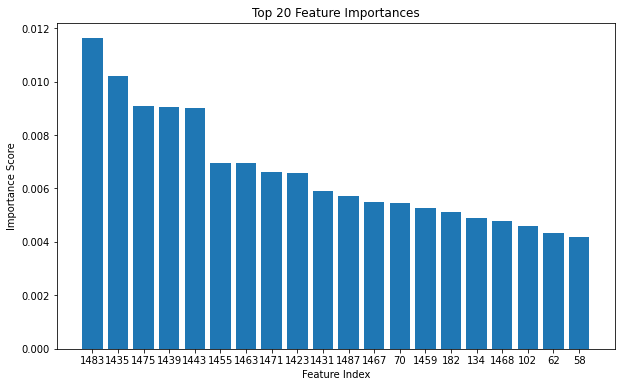

In [96]:
feature_importances = classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot first 50 feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), feature_importances[indices[:20]], align="center")
plt.xticks(range(20), indices[:20])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

[1751, 214, 451, 1894, 831, 1929, 1238, 1242, 808, 207, 298, 344, 720, 1276, 751, 1966, 1008, 1030, 1089, 308, 1545, 449, 1163, 1022, 1833, 220, 1560, 1673, 780, 28, 1453, 1500, 1860, 339, 660, 250, 1630, 1051, 865, 968, 297, 61, 1597, 95, 1255, 1411, 1085, 738, 1178, 170, 1266, 971, 629, 1038, 1297, 469, 154, 305, 235, 918, 1408, 772, 82, 1952, 903, 1438, 735, 530, 691, 864, 1601, 321, 1722, 869, 1425, 1663, 951, 523, 673, 54, 609, 1396, 1420, 502, 759, 380, 430, 345, 439, 1726, 1412, 713, 19, 1949, 589, 1639, 1816, 1167, 1509, 745, 752, 800, 468, 1347, 90, 917, 461, 53, 1814, 1171, 127, 1388, 961, 1610, 1225, 1462, 1304, 1788, 790, 363, 642, 891, 1265, 526, 416, 38, 537, 612, 1428, 338, 288, 1405, 1503, 208, 1402, 447, 242, 77, 1169, 1159, 1468, 791, 372, 1262, 1922, 272, 1613, 576, 475, 1331, 557, 1243, 1146, 726, 383, 1025, 1647, 1777, 858, 615, 804, 1308, 349, 1556, 1140, 957, 1627, 1373, 261, 1098, 1953, 71, 1311, 1542, 989, 977, 1771, 1251, 1539, 246, 1067, 1680, 102, 1342, 1541

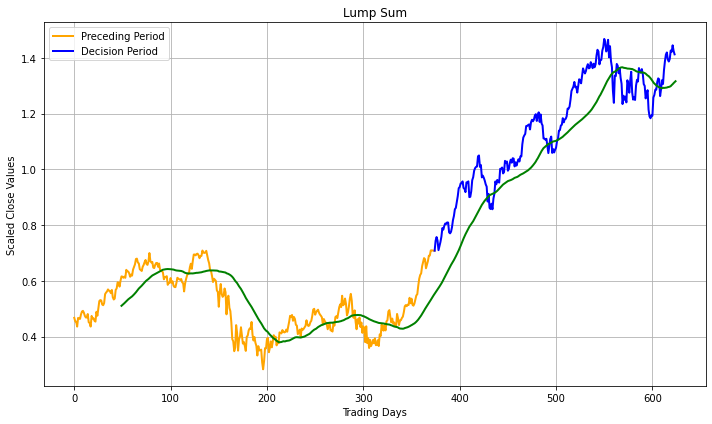

[1934, 904, 452, 35, 1084, 480, 1923, 486, 998, 155, 418, 652, 1139, 1617, 702, 59, 1559, 1480, 1737, 678, 274, 1705, 1351, 34, 1882, 222, 1144, 1057, 248, 848, 487, 1479, 1201, 1835, 1370, 1065, 1203, 672, 767, 135, 834, 371, 1711, 1533, 1489, 611, 799, 1808, 1166, 899, 684, 1196, 656, 293, 651, 1983, 1128, 626, 620, 690, 928, 762, 1797, 1391, 1314, 458, 143, 591, 22, 1335, 1102, 186, 1634, 463]


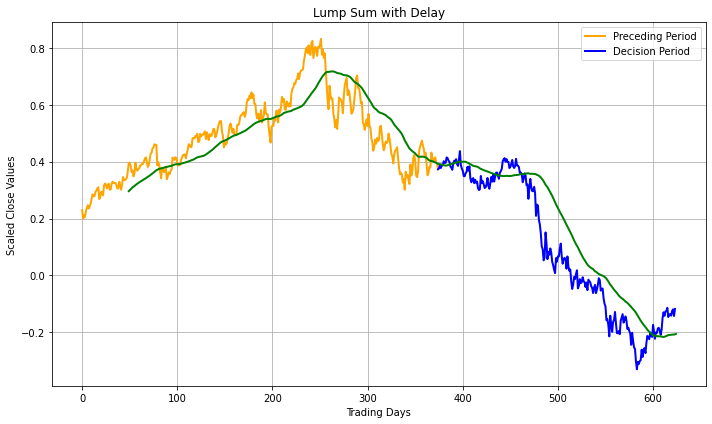

[72, 528, 1640, 1665, 1215, 79, 179, 1156, 881, 1979, 1004, 1423, 635, 1224, 488, 294, 397, 1513, 680, 534, 1343, 1149, 1329, 766, 386, 887, 145, 234, 1696, 1066, 97, 436, 1757, 1616, 788, 1548, 549, 1088, 162, 1914, 1988, 880, 1032, 1221, 1969, 406, 668, 1035, 1644, 542, 1919, 489, 290, 1853, 547, 1859, 1652, 316, 1884, 830, 275, 1567, 1521, 268, 1916, 238, 1231, 915, 1433, 1568, 1973, 1764, 776, 1096, 552, 1883, 1743, 760]


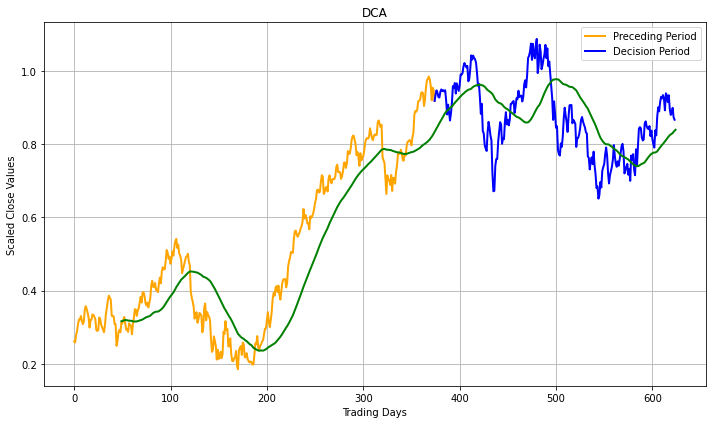

In [97]:
for strategy in ["Lump Sum", "Lump Sum with Delay", "DCA"]:
#for strategy in ["Lump Sum"]:
#for strategy in ["Lump Sum with Delay"]:
#for strategy in ["DCA"]:
    matching_delay_indices = []
    resetted_index = y_test.reset_index()

    # Iterate over the indices and the values of y_test and y_pred
    for idx, (actual, predicted) in enumerate(zip(y_test, y_pred)):
        if actual == predicted == strategy:
            matching_delay_indices.append(resetted_index.loc[idx]["index"])
    print(matching_delay_indices)

    start_dates = [results.loc[i]["Start Date"] for i in matching_delay_indices]
    end_dates = [results.loc[i]["End Date"] for i in matching_delay_indices]
    lump_sum_dates = [results.loc[i]["Lump Sum Date"] for i in matching_delay_indices] 
    show_graph = True

    final_1 = [0.5] * int(int(train_years * 12)*250/12)   # Initialize final variable for the first line
    final_2 = [0.5] * int(int(test_years * 12)*250/12)    # Initialize final variable for the second line

    for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
        #new_date = (lump_sum_date - timedelta(days=365 * train_years))
        #data = sandp_time['close'][new_date:lump_sum_date]
        new_date = (start_date - timedelta(days=365 * train_years))
        data = sandp_time['close'][new_date:start_date]
        scaled = (data - data.min()) / (data.max() - data.min())
        scaled = np.array(scaled)[len(scaled)-len(final_1):]
        #print(len(scaled))
        if len(scaled) == len(final_1):
            final_1 = (final_1 + scaled) / 2  # Aggregate with the first final variable


        # Calculate the second final variable
        #end_data = sandp_time['close'][lump_sum_date:lump_sum_date + timedelta(days=365 * test_years)]
        #print(lump_sum_date,lump_sum_date + timedelta(days=365 * test_years))
        end_data = sandp_time['close'][start_date:start_date + timedelta(days=365 * test_years)]
        scaled_end = (end_data - end_data.min()) / (end_data.max() - end_data.min())
        scaled_end = np.array(scaled_end)[len(scaled_end)-len(final_2):]
        if len(scaled_end) == len(final_2):
            final_2 = (final_2 + scaled_end) / 2  # Aggregate with the second final variable


    # Plot the first line
    final_2 = final_2+(final_1[-1]-final_2[0])
    
    plt.figure(figsize=(10, 6))
    plt.plot(final_1, color='orange', linewidth=2, linestyle='-')
    
    # Plot the second line
    plt.plot(range(len(final_1) - 1, len(final_1) + len(final_2) - 1), final_2, color='blue', linewidth=2, linestyle='-')

    combined_final = np.concatenate([final_1,final_2])
    moving_average = pd.Series(combined_final).rolling(window=50).mean()
    plt.plot(moving_average, color='green', linestyle='-', linewidth=2)

    
    plt.title(strategy)
    plt.xlabel('Trading Days')
    plt.ylabel('Scaled Close Values')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(['Preceding Period', 'Decision Period'], loc='best')
    plt.show()

Initial Date : 2000-01-14
Start Date   : 2000-07-20 00:00:00
Lump Sum Date: 2002-07-15
End Date     : 2002-07-20


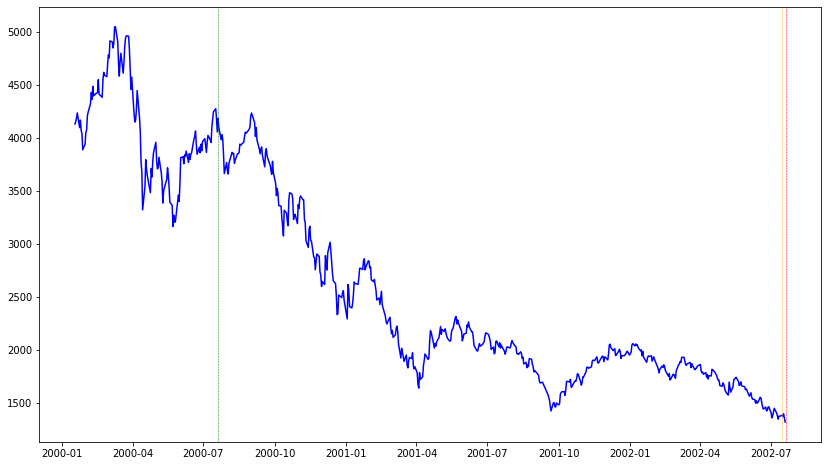

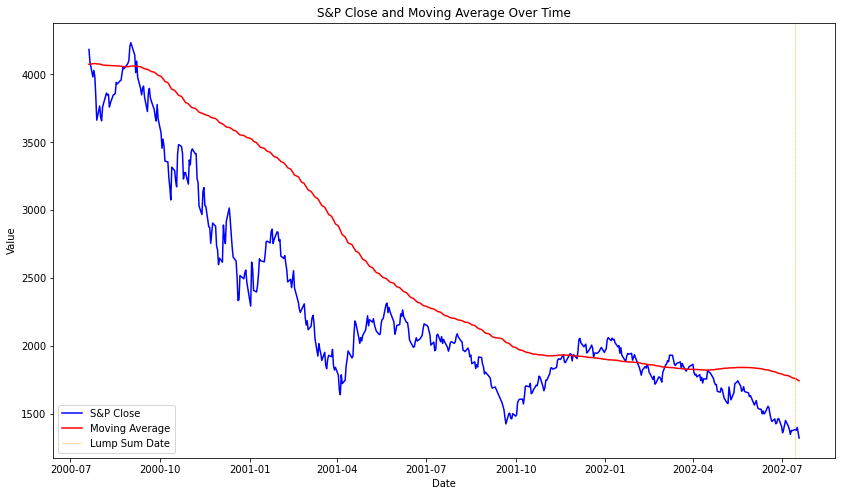

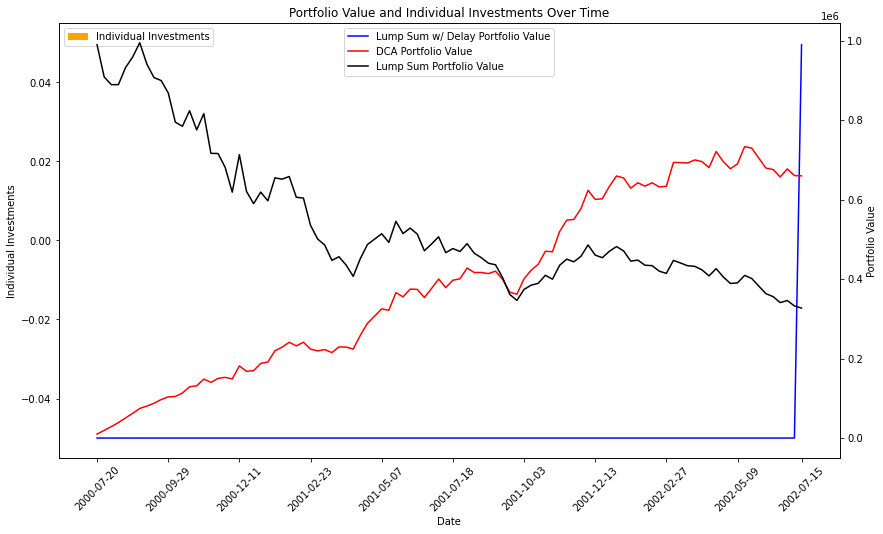

Initial Date : 2000-08-28
Start Date   : 2001-02-27 00:00:00
Lump Sum Date: 2003-02-27
End Date     : 2003-02-27


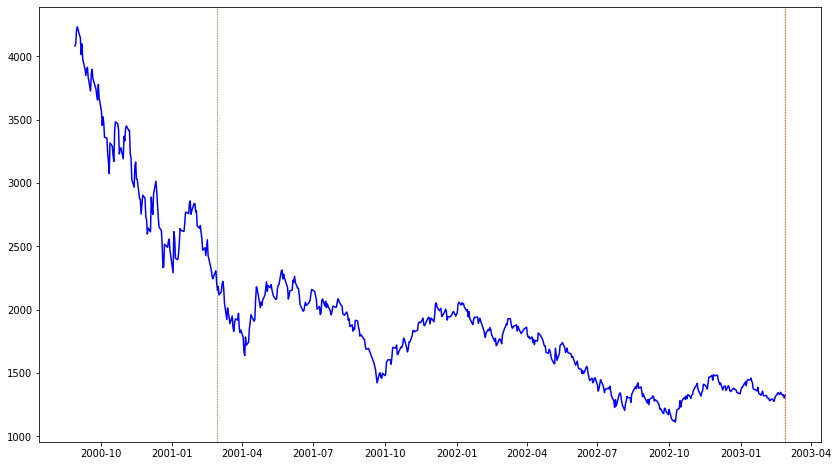

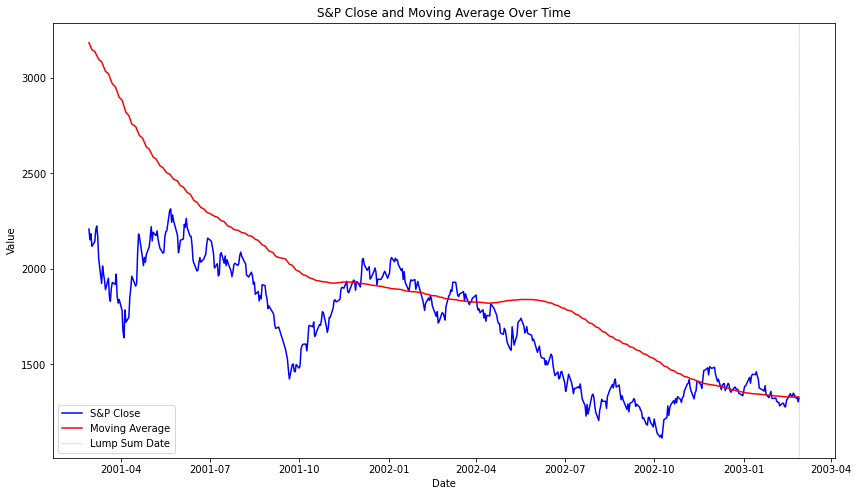

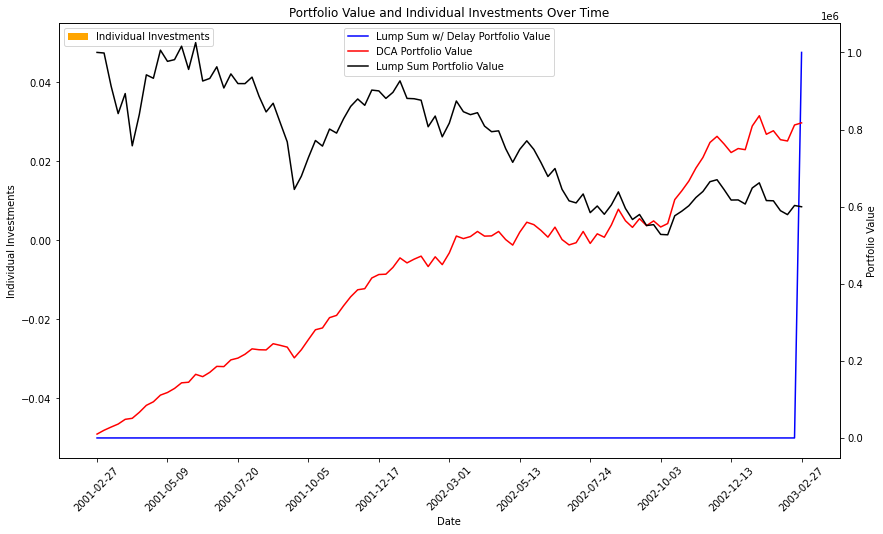

Initial Date : 2000-03-28
Start Date   : 2000-09-27 00:00:00
Lump Sum Date: 2002-09-27
End Date     : 2002-09-27


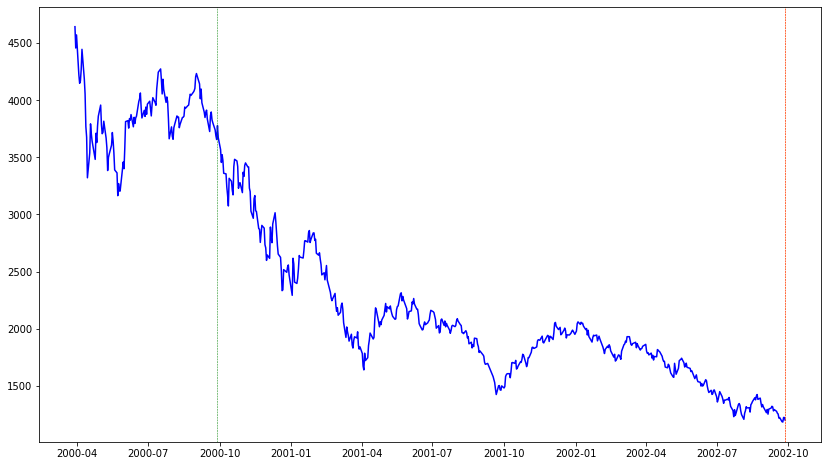

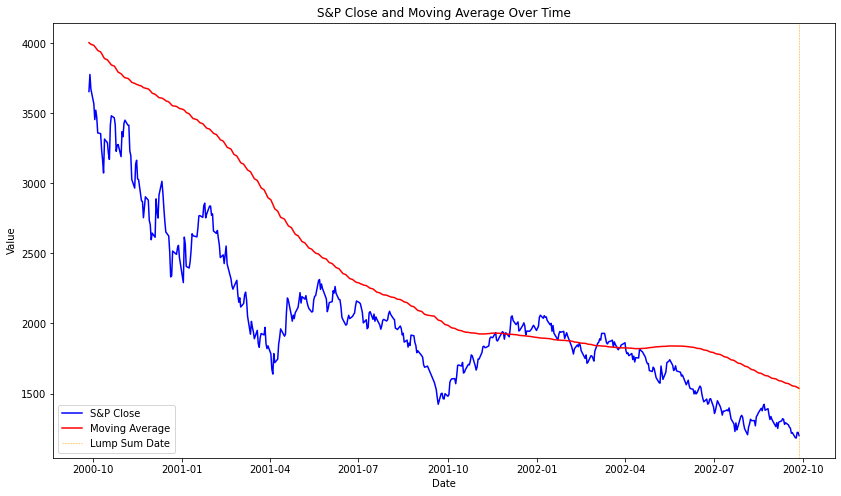

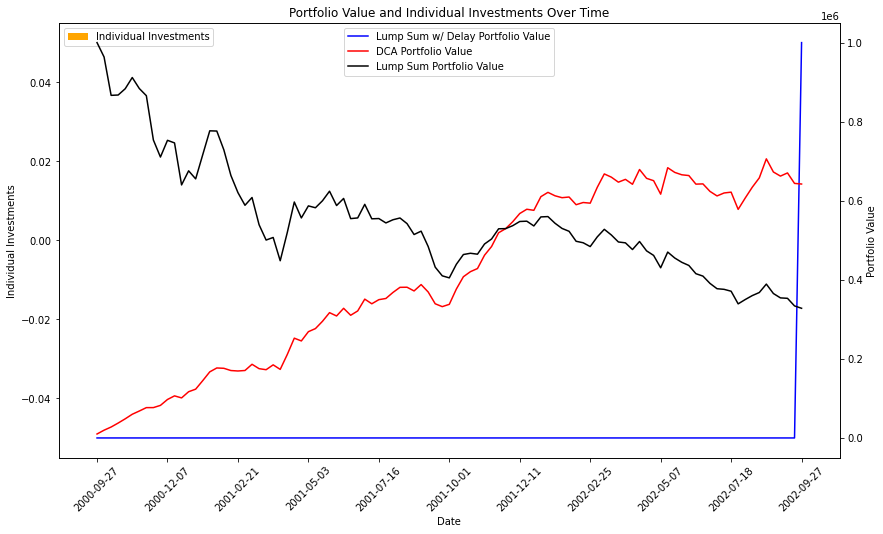

Initial Date : 2000-10-06
Start Date   : 2001-04-12 00:00:00
Lump Sum Date: 2003-04-07
End Date     : 2003-04-12


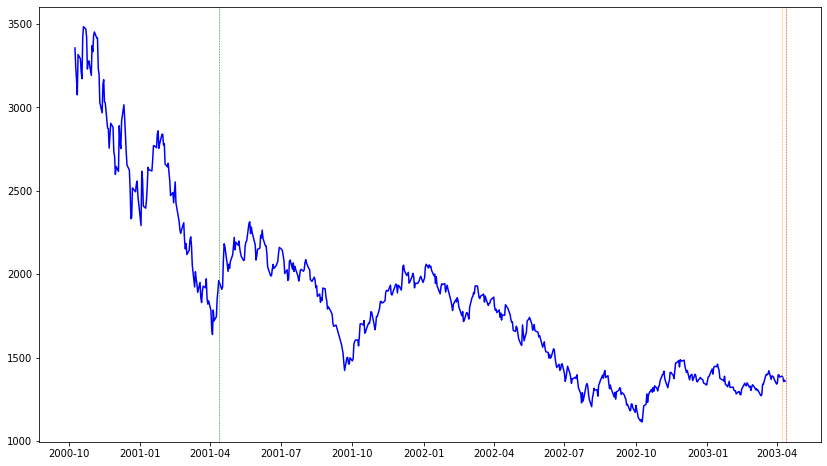

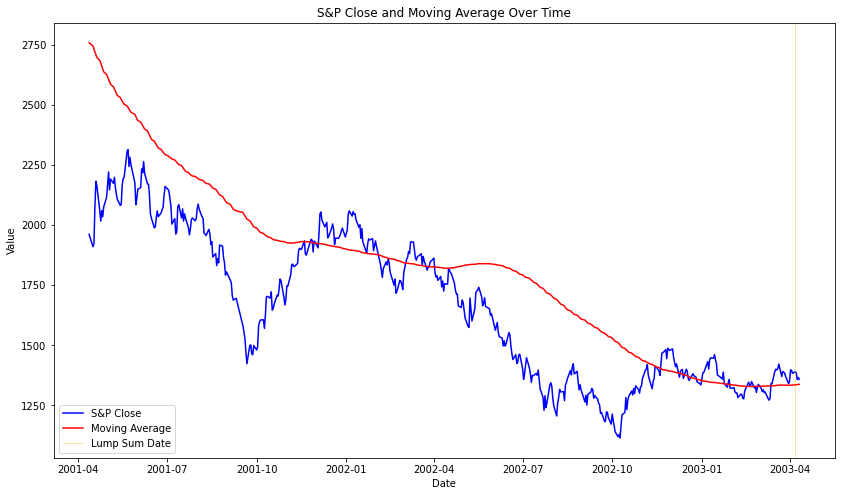

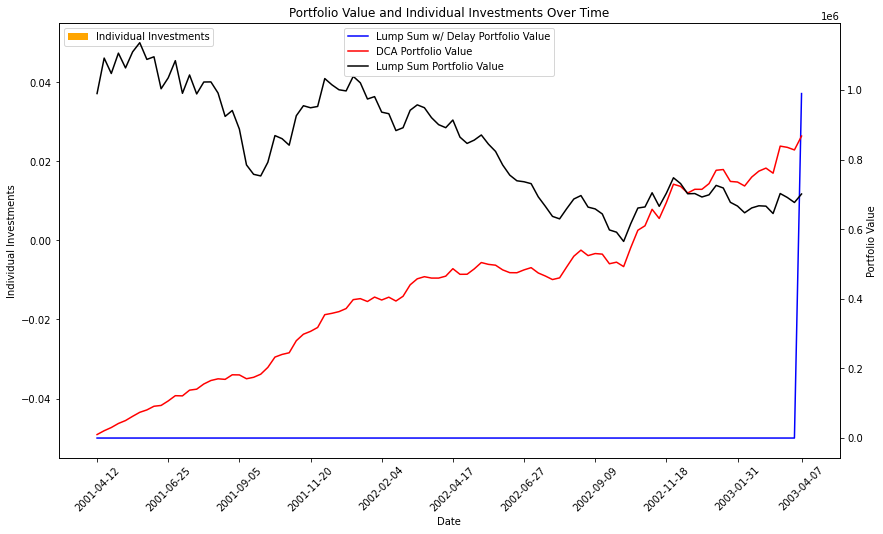

Initial Date : 2000-04-14
Start Date   : 2000-10-19 00:00:00
Lump Sum Date: 2002-10-14
End Date     : 2002-10-19


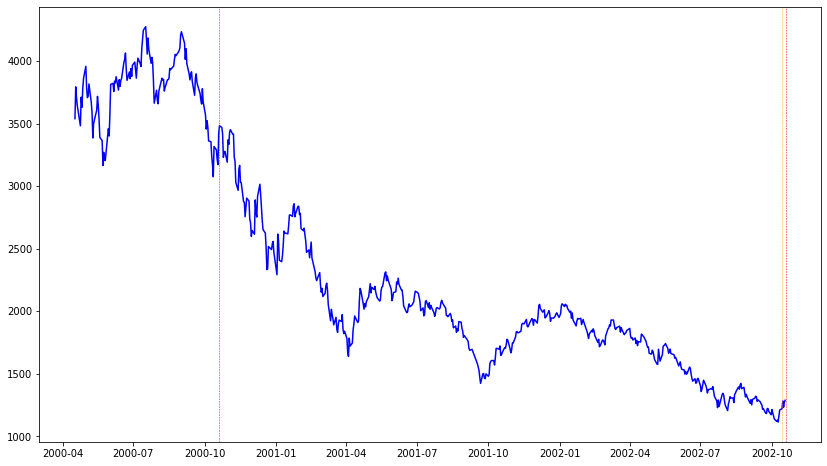

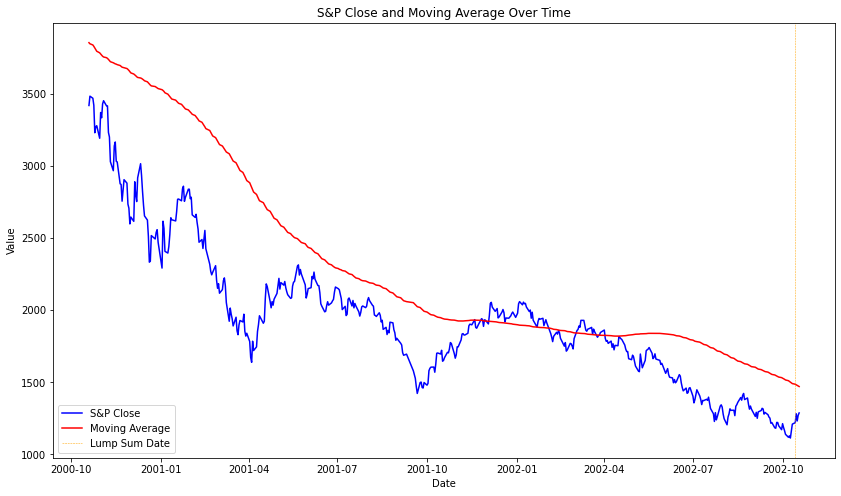

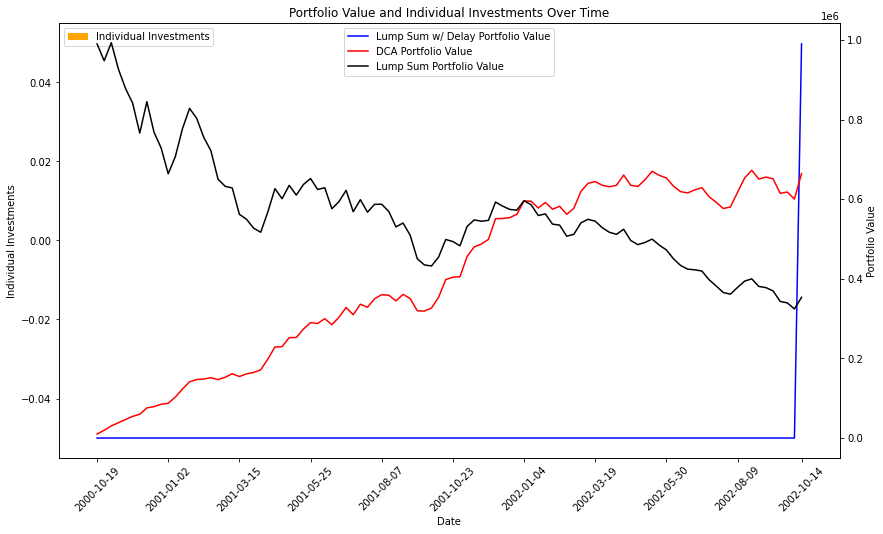

Initial Date : 2000-07-11
Start Date   : 2001-01-10 00:00:00
Lump Sum Date: 2003-01-10
End Date     : 2003-01-10


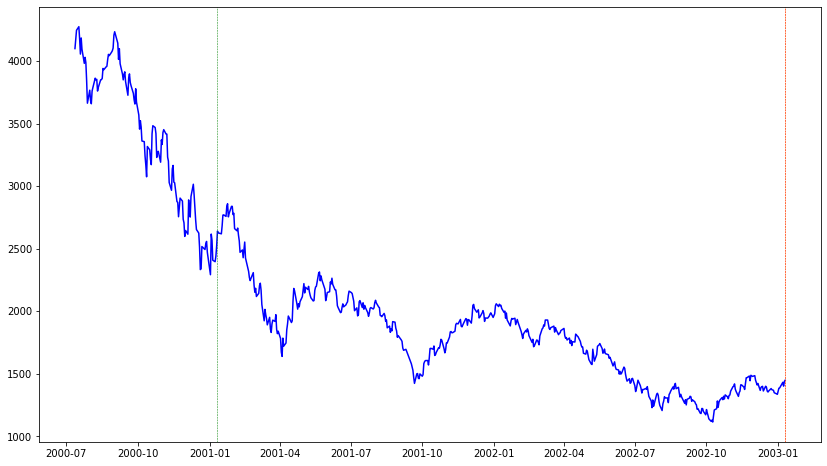

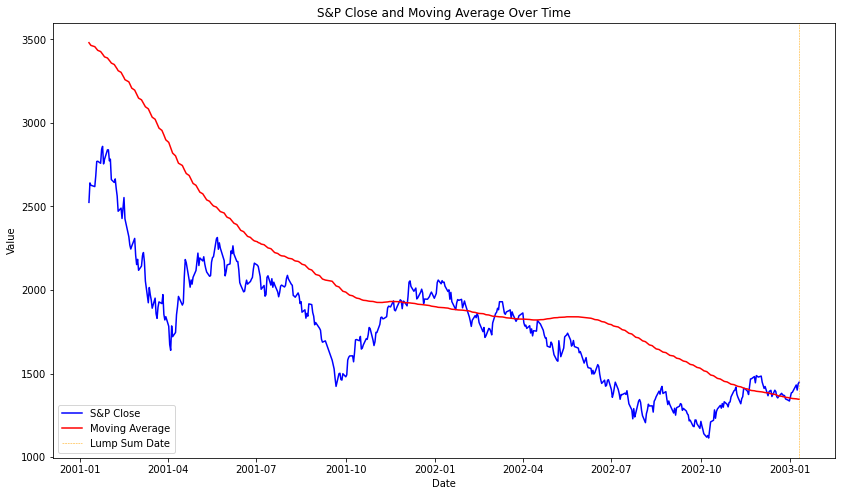

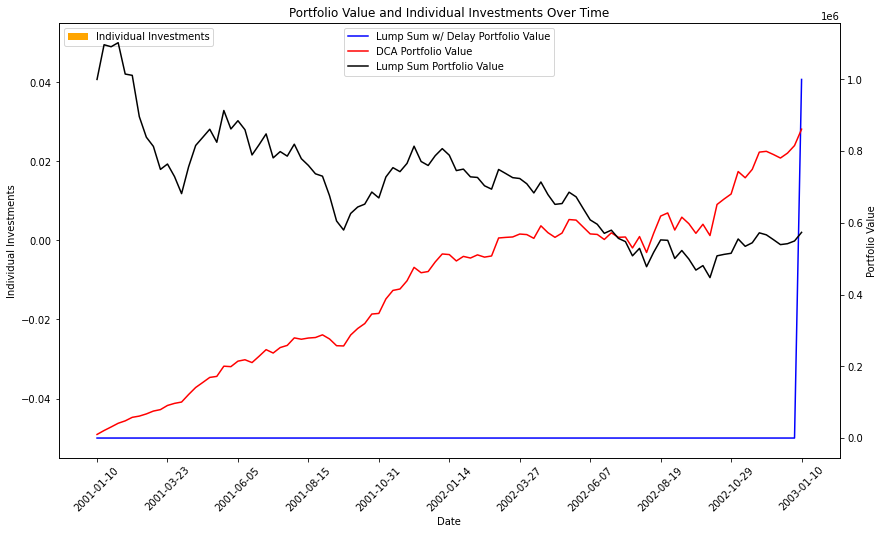

Initial Date : 2000-06-18
Start Date   : 2000-12-18 00:00:00
Lump Sum Date: 2002-12-18
End Date     : 2002-12-18


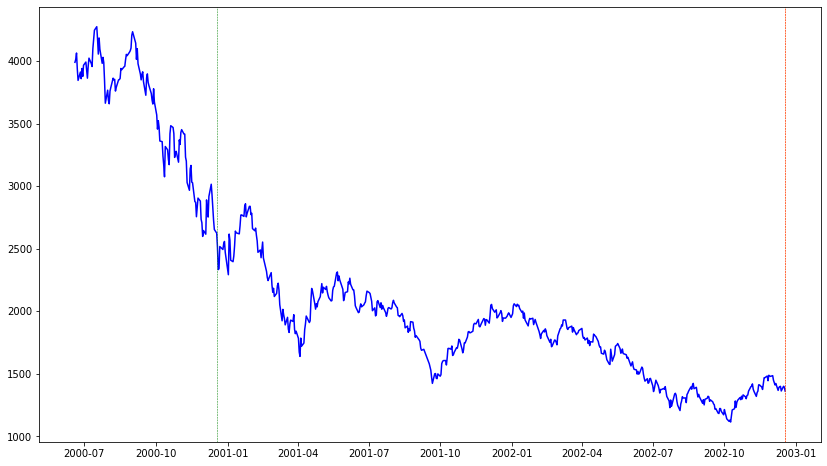

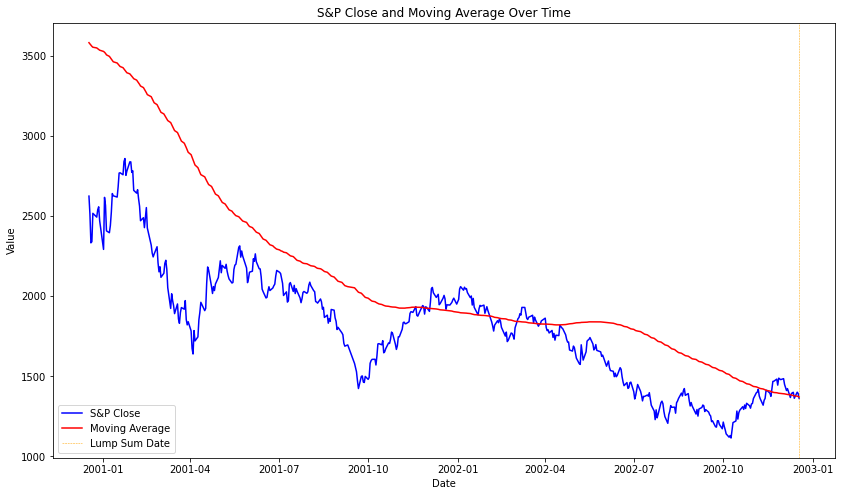

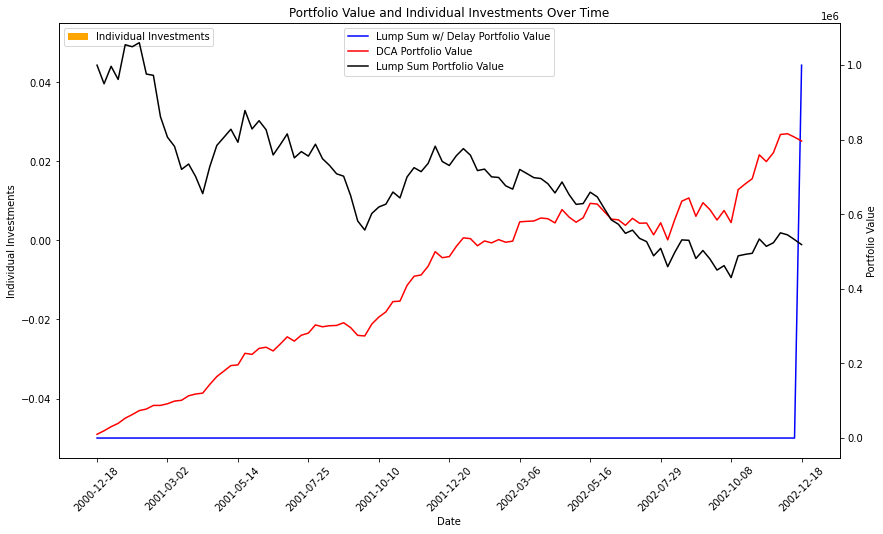

Initial Date : 2000-08-01
Start Date   : 2001-01-31 00:00:00
Lump Sum Date: 2003-01-31
End Date     : 2003-01-31


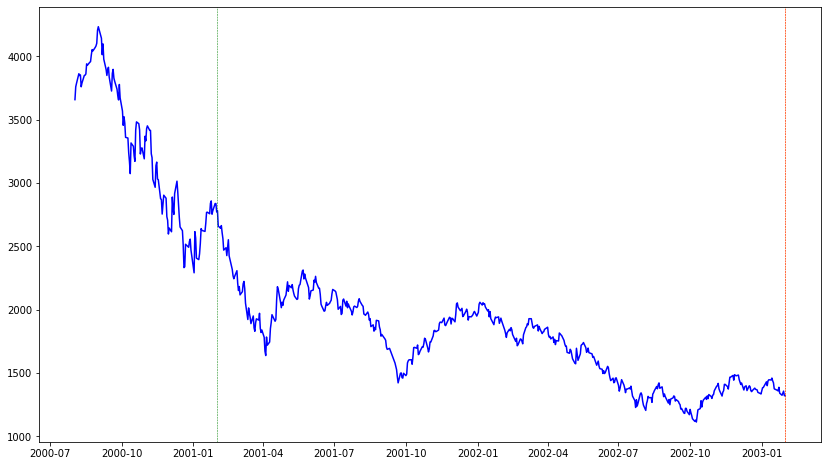

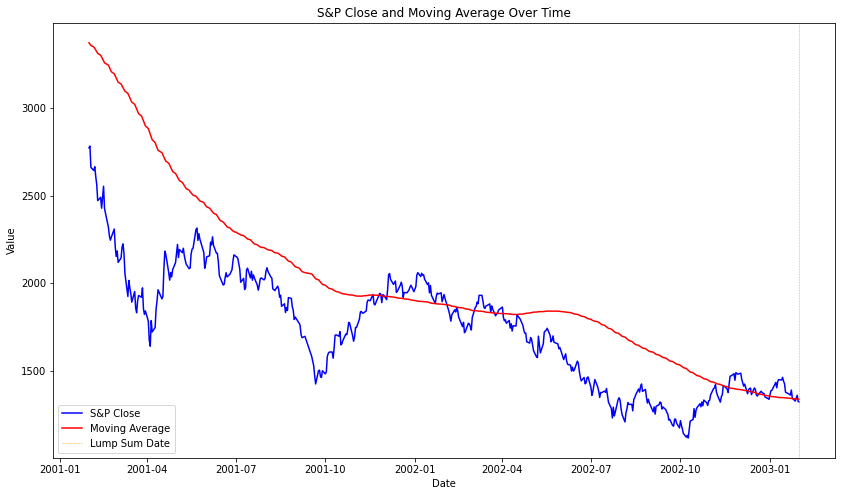

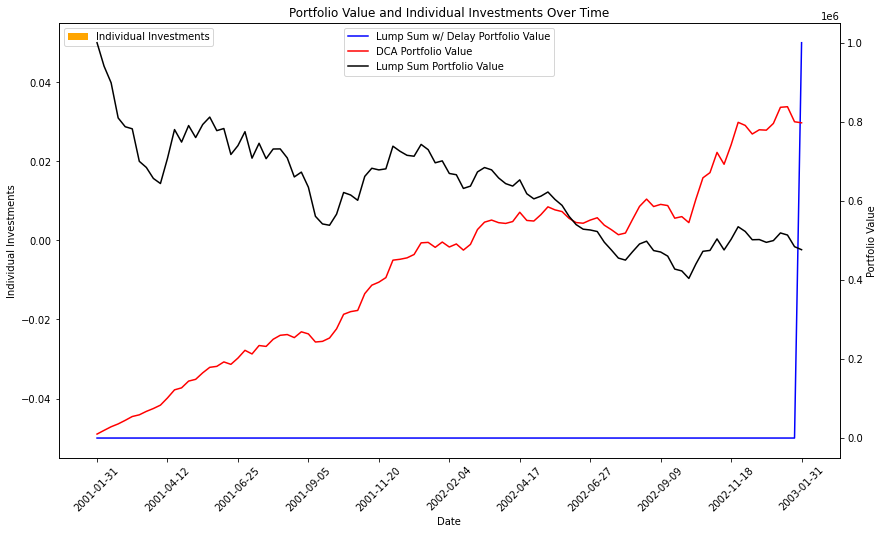

Initial Date : 2000-07-08
Start Date   : 2001-01-12 00:00:00
Lump Sum Date: 2003-01-07
End Date     : 2003-01-12


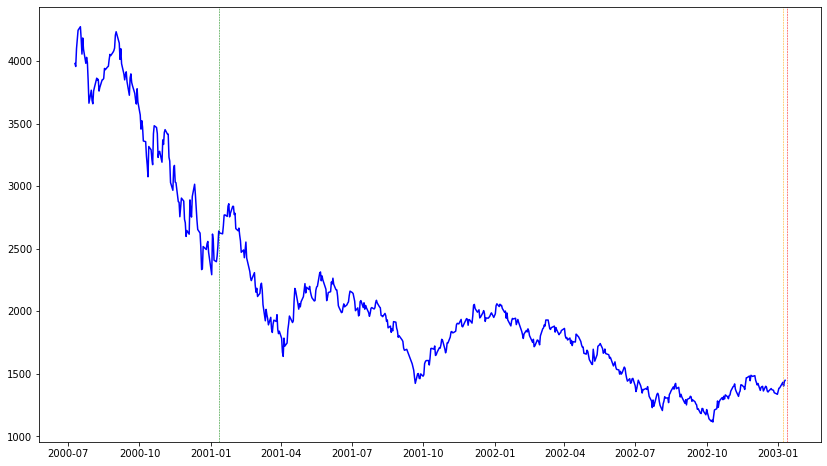

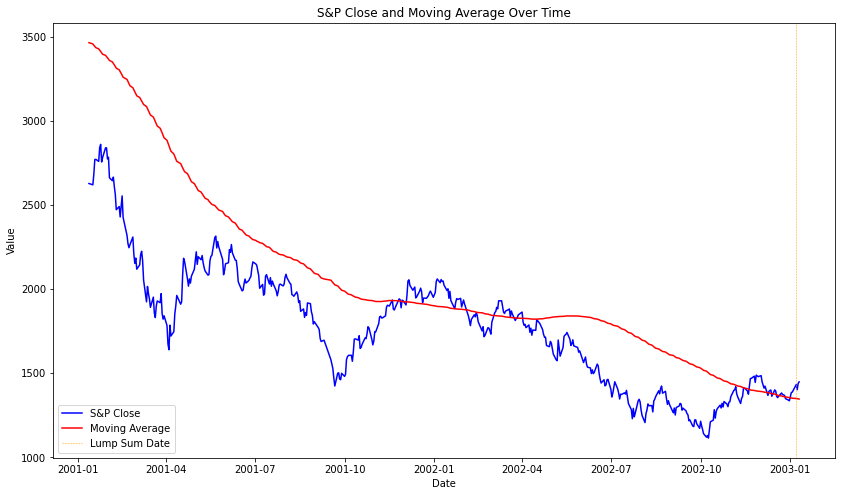

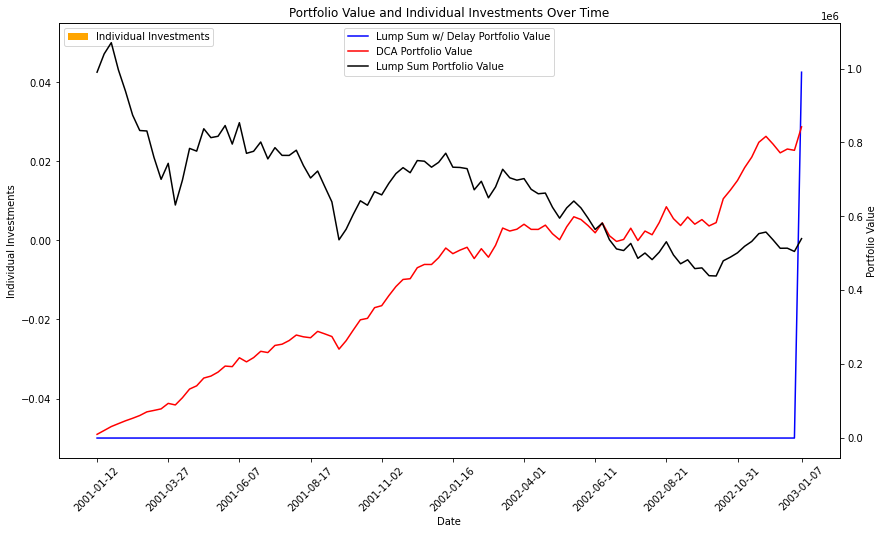

Initial Date : 1999-12-10
Start Date   : 2000-06-15 00:00:00
Lump Sum Date: 2002-06-10
End Date     : 2002-06-15


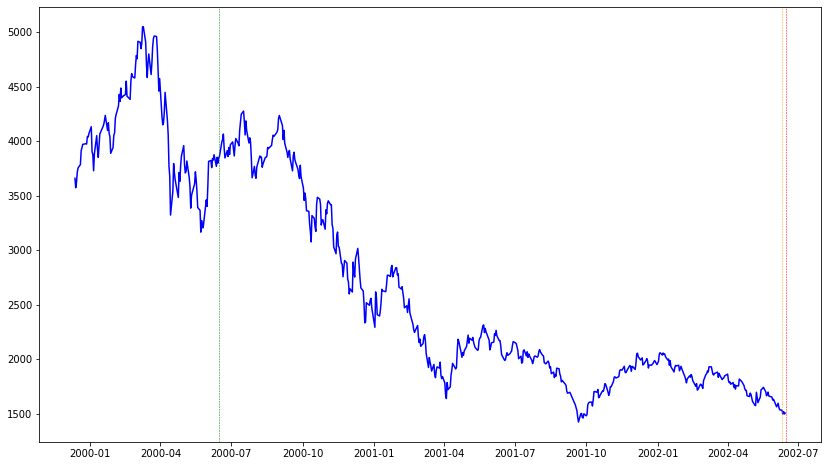

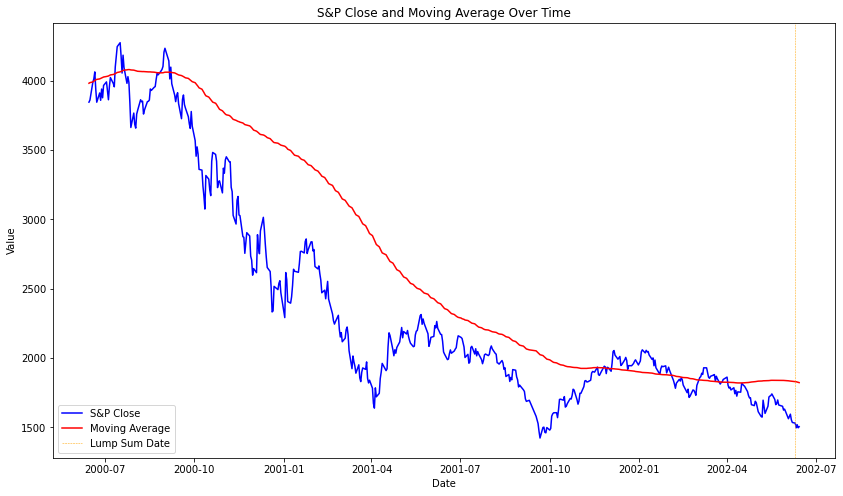

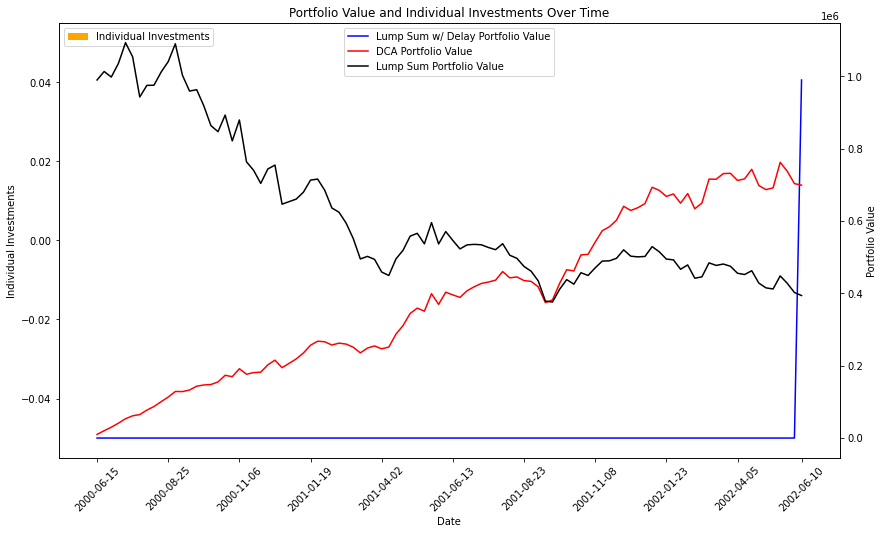

Initial Date : 2000-04-09
Start Date   : 2000-10-09 00:00:00
Lump Sum Date: 2002-10-09
End Date     : 2002-10-09


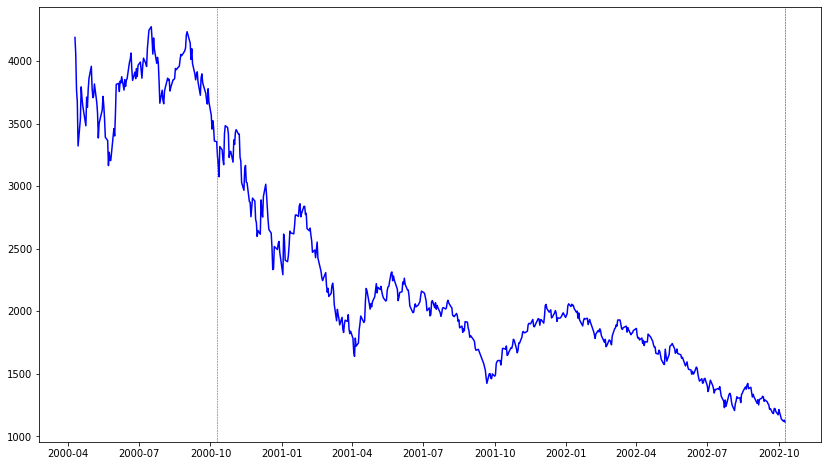

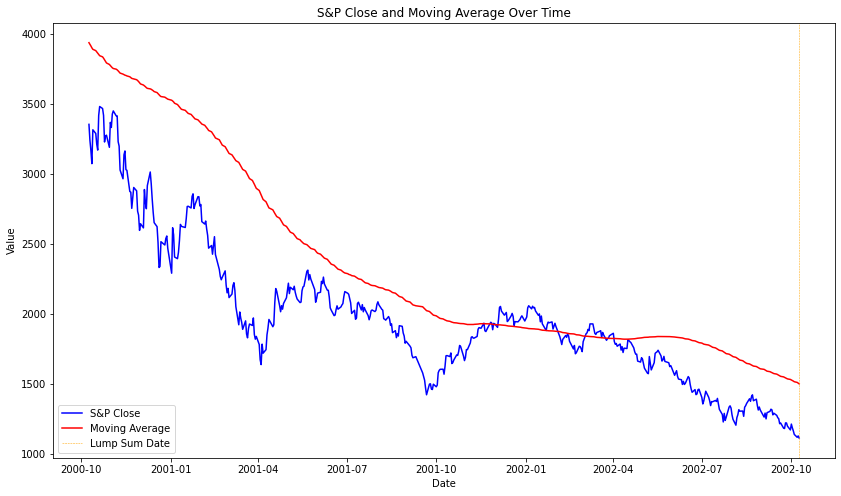

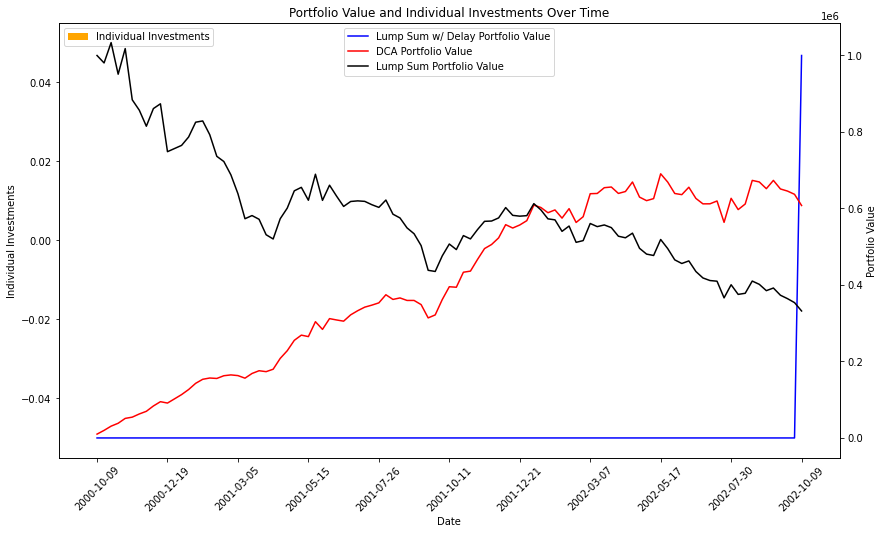

Initial Date : 1999-12-31
Start Date   : 2000-07-07 00:00:00
Lump Sum Date: 2002-07-01
End Date     : 2002-07-07


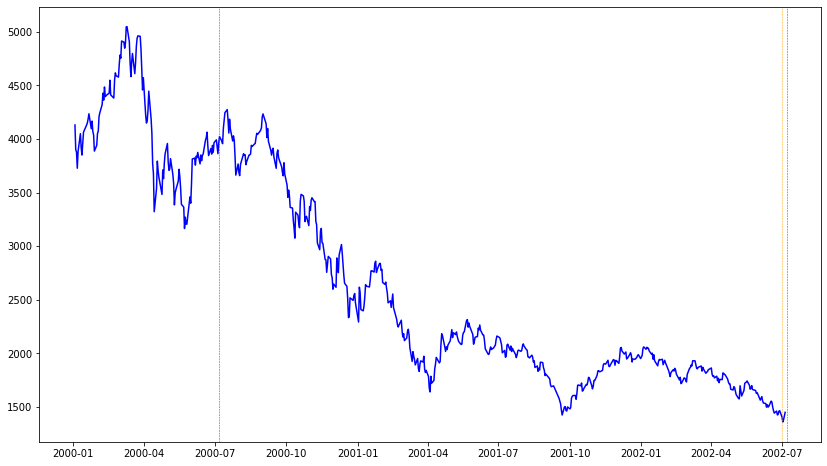

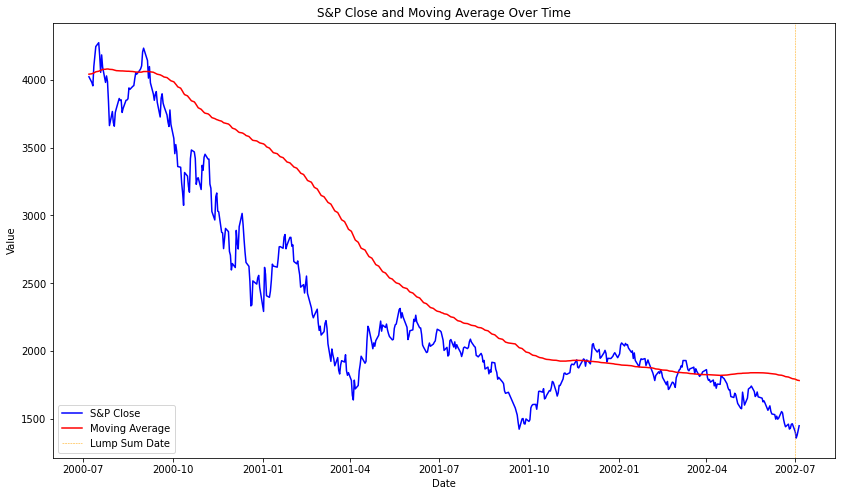

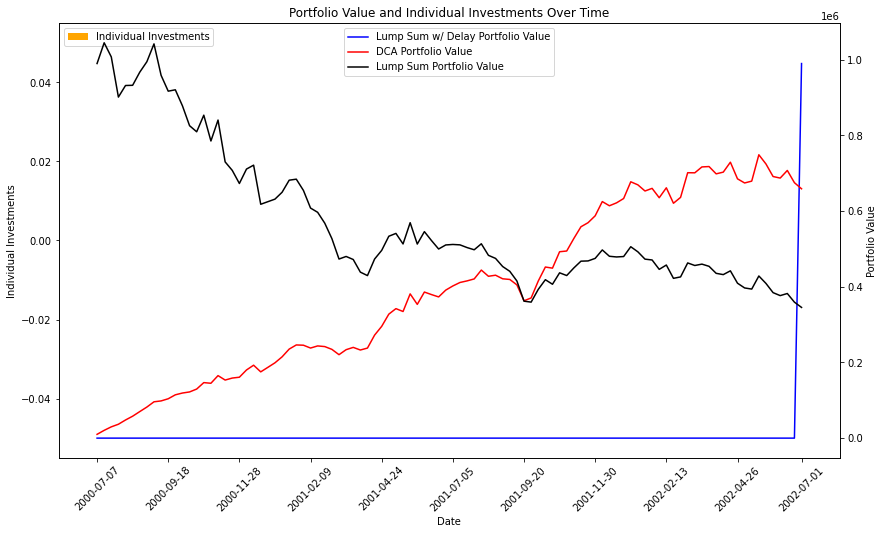

Initial Date : 2000-06-06
Start Date   : 2000-12-06 00:00:00
Lump Sum Date: 2002-12-06
End Date     : 2002-12-06


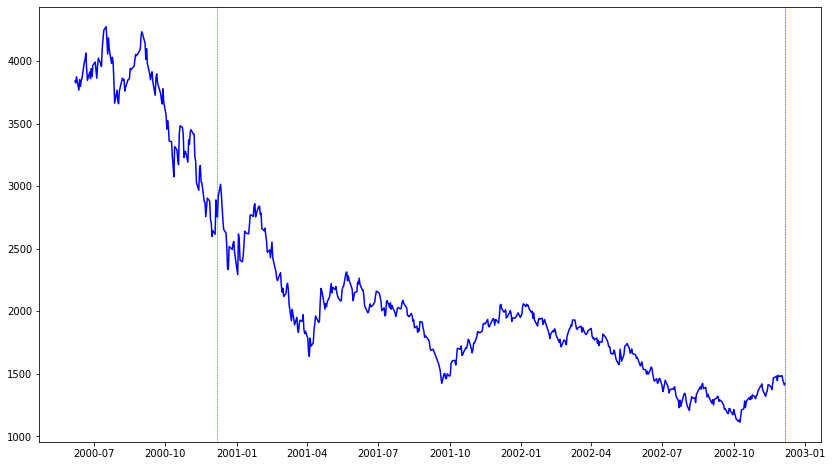

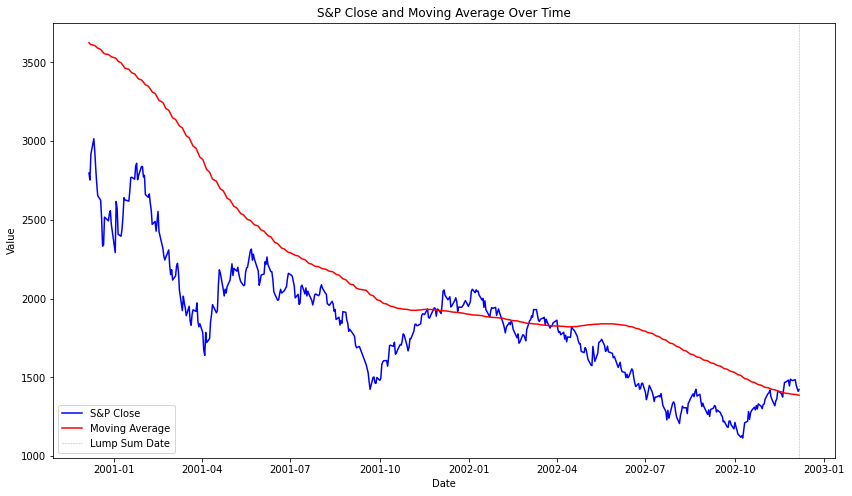

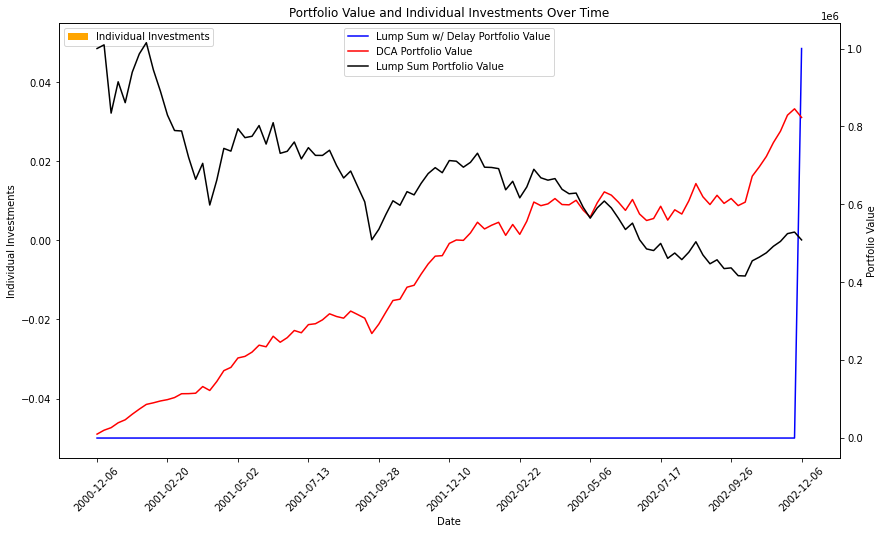

Initial Date : 1999-11-23
Start Date   : 2000-05-24 00:00:00
Lump Sum Date: 2002-05-24
End Date     : 2002-05-24


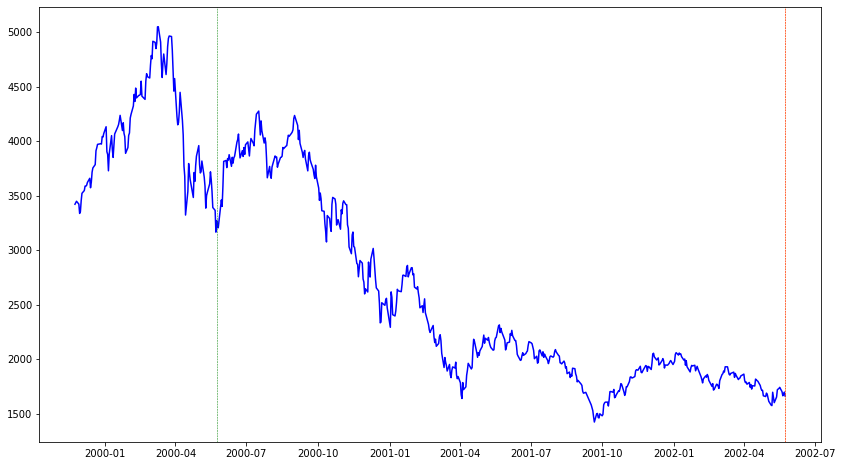

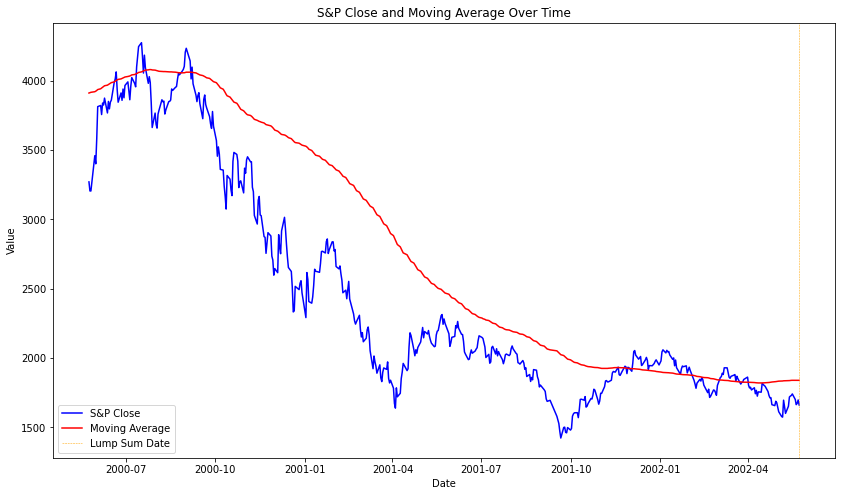

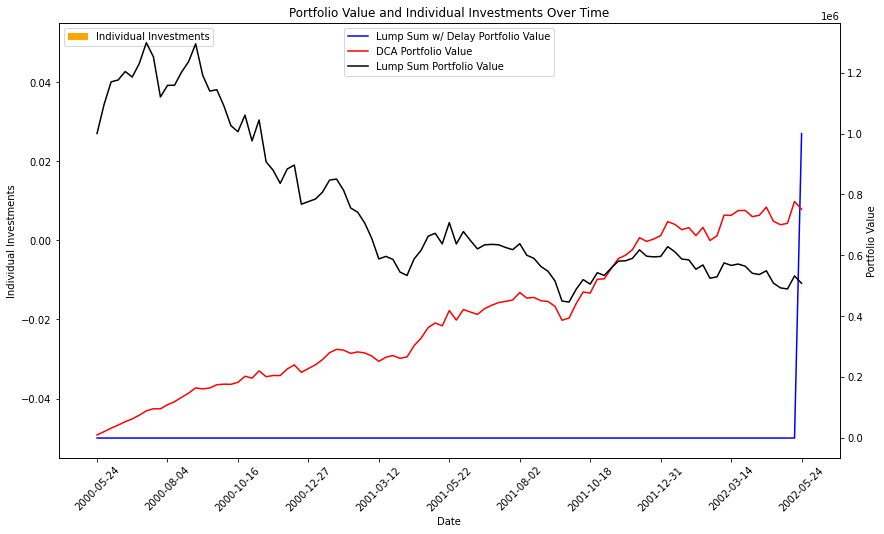

Initial Date : 2000-02-13
Start Date   : 2000-08-14 00:00:00
Lump Sum Date: 2002-08-14
End Date     : 2002-08-14


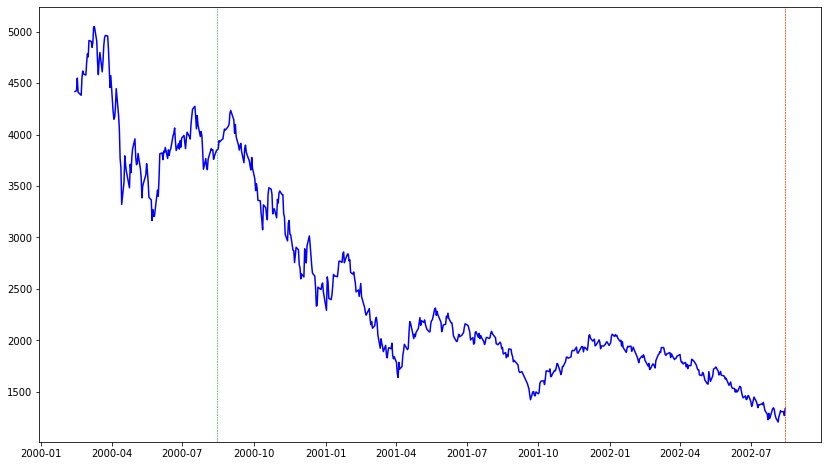

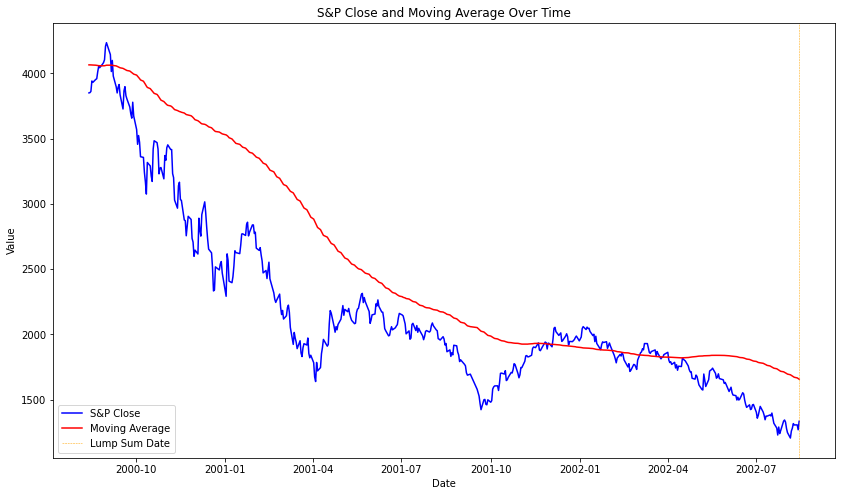

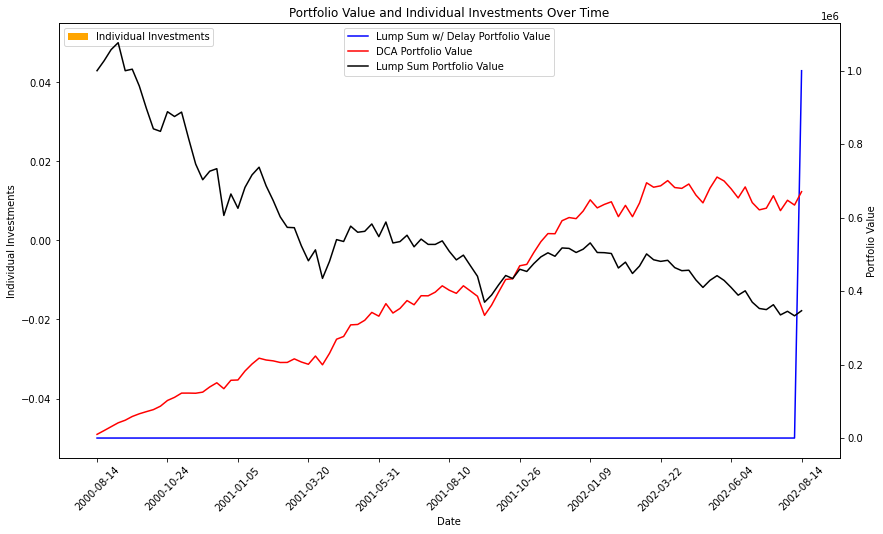

Initial Date : 2000-02-22
Start Date   : 2000-08-23 00:00:00
Lump Sum Date: 2002-08-23
End Date     : 2002-08-23


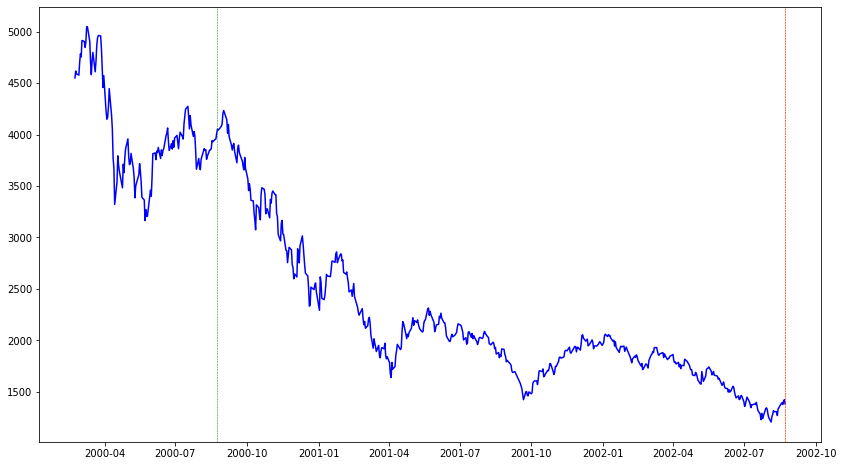

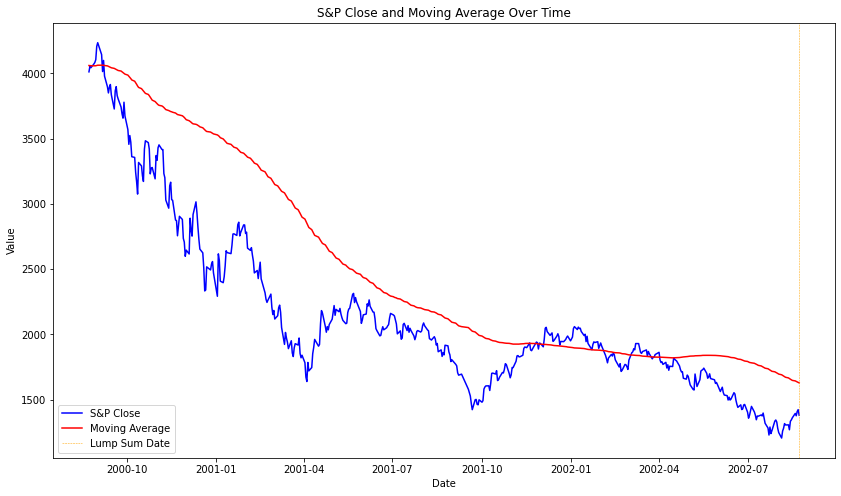

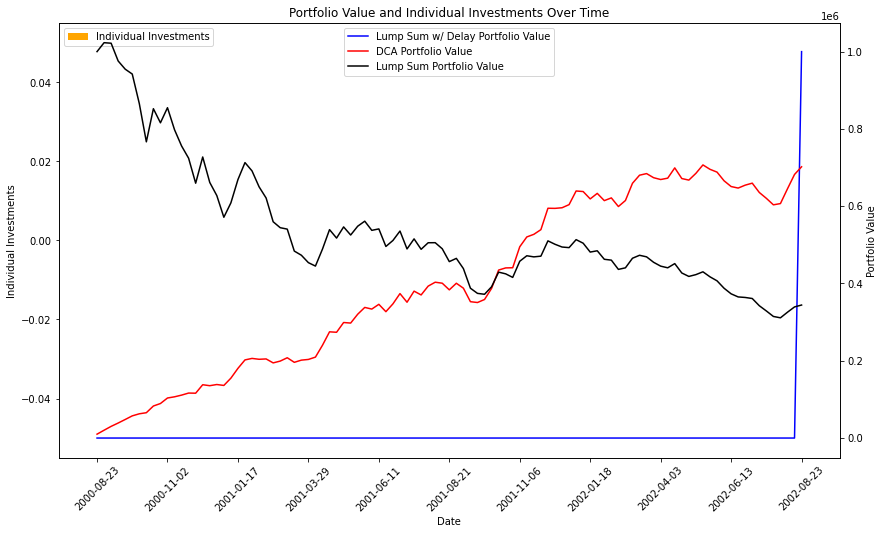

Initial Date : 2000-02-04
Start Date   : 2000-08-10 00:00:00
Lump Sum Date: 2002-08-05
End Date     : 2002-08-10


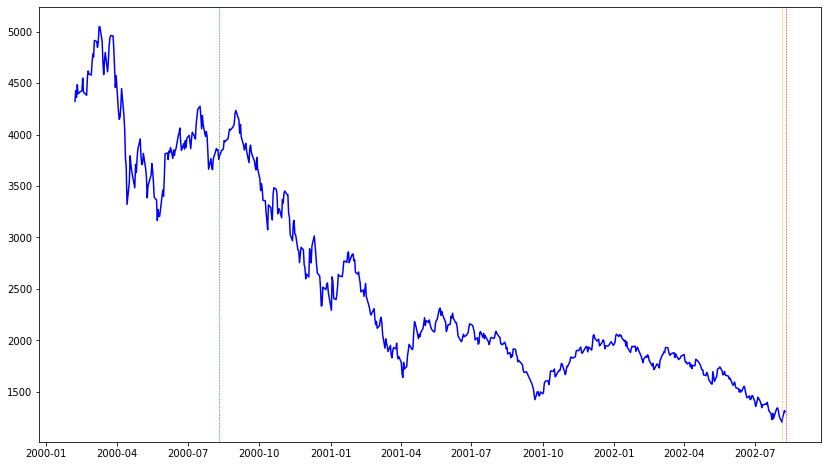

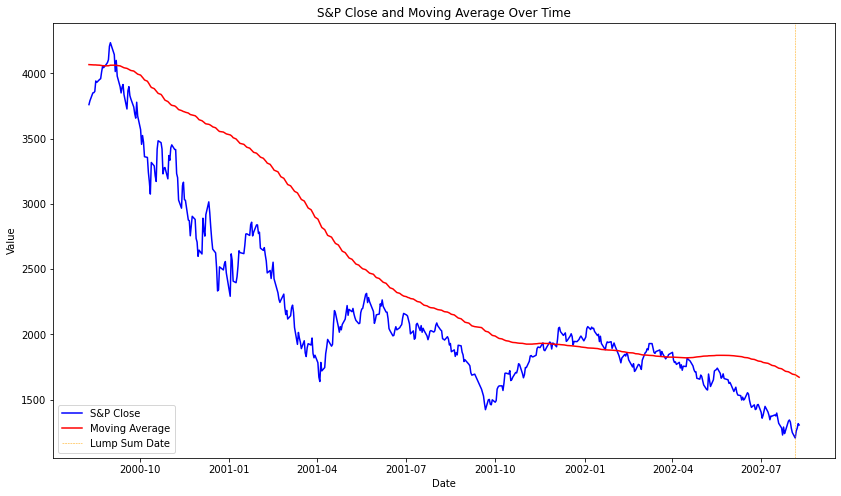

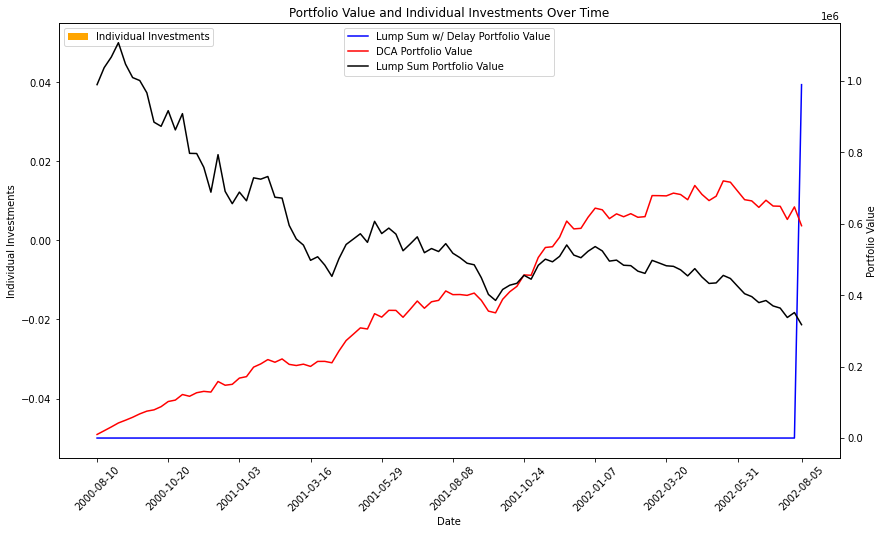

Initial Date : 1999-11-21
Start Date   : 2000-05-22 00:00:00
Lump Sum Date: 2002-05-22
End Date     : 2002-05-22


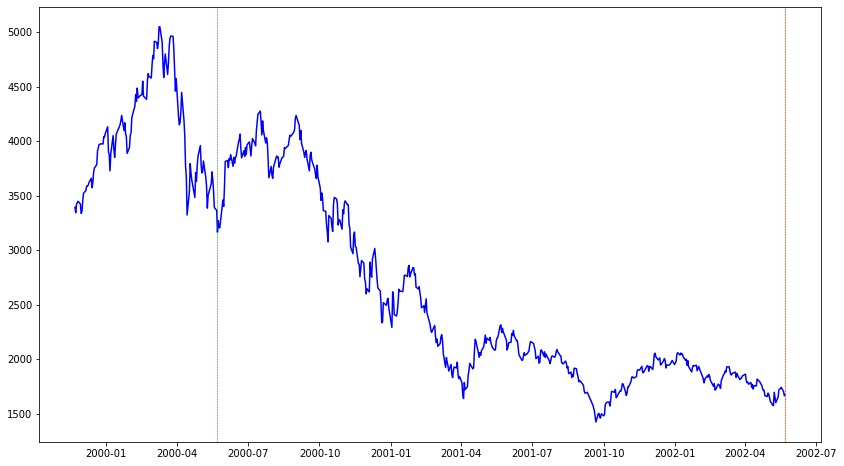

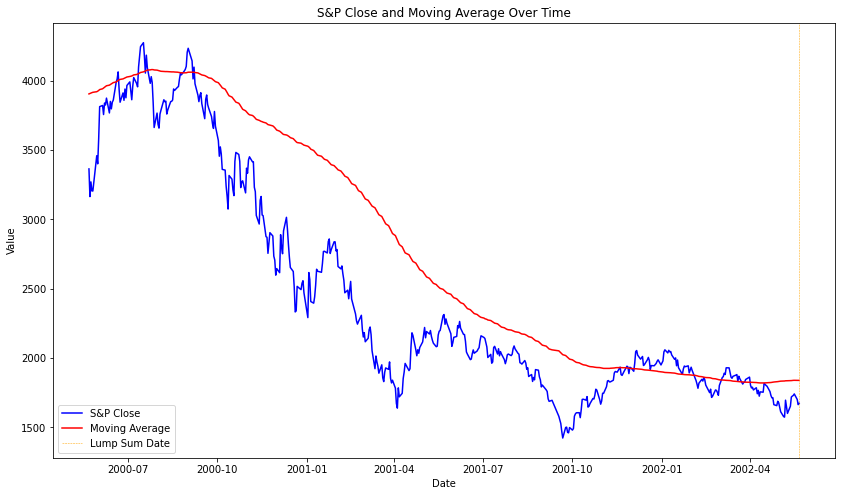

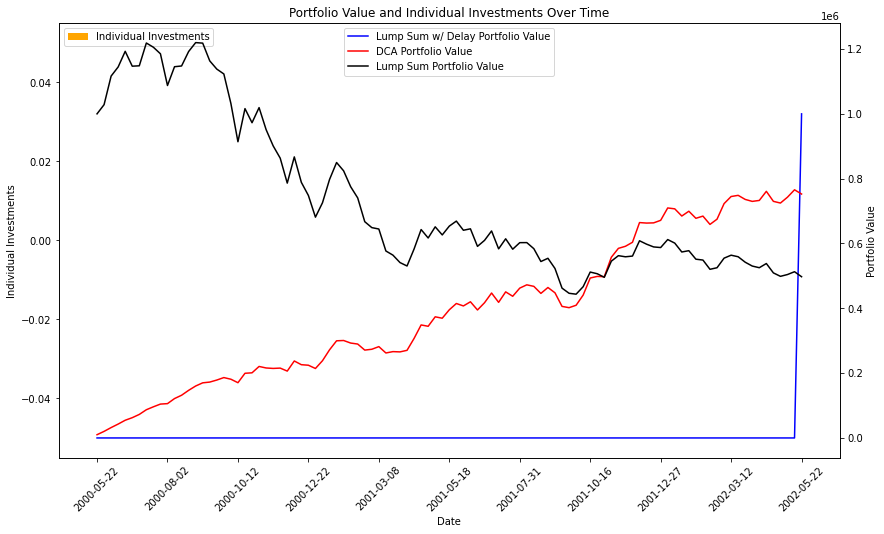

Initial Date : 2000-02-21
Start Date   : 2000-08-22 00:00:00
Lump Sum Date: 2002-08-22
End Date     : 2002-08-22


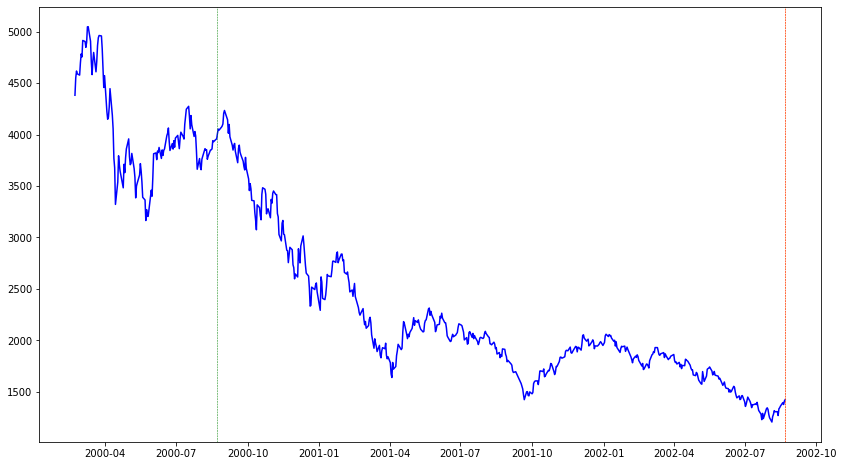

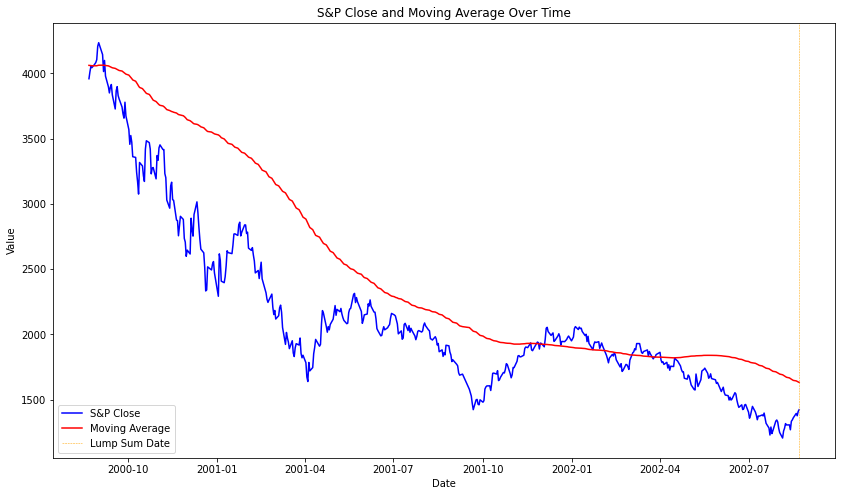

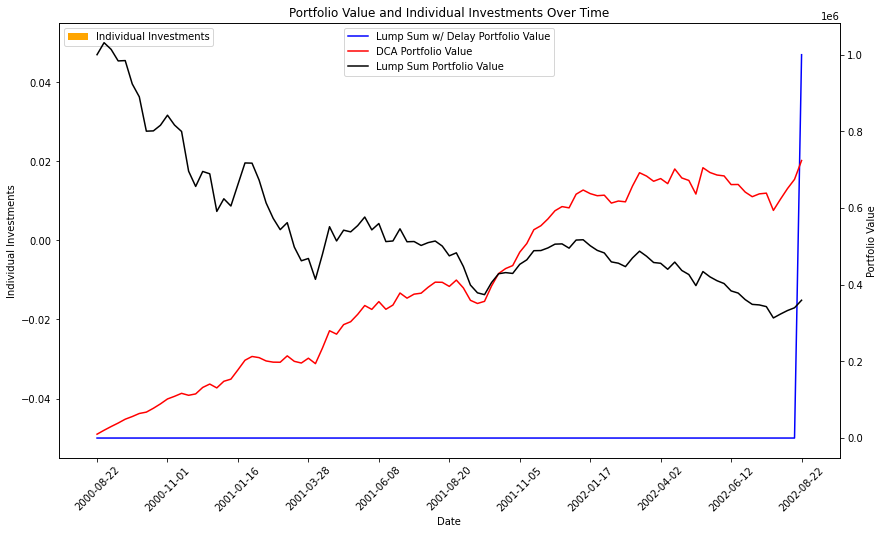

Initial Date : 2000-09-05
Start Date   : 2001-03-07 00:00:00
Lump Sum Date: 2003-03-07
End Date     : 2003-03-07


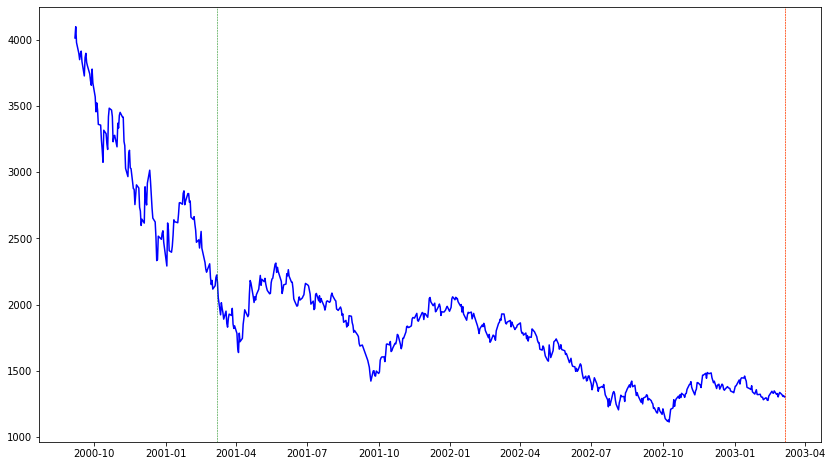

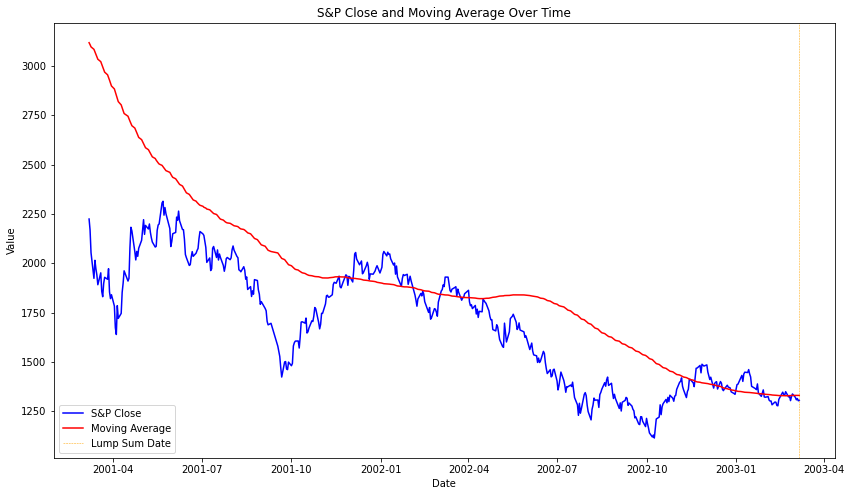

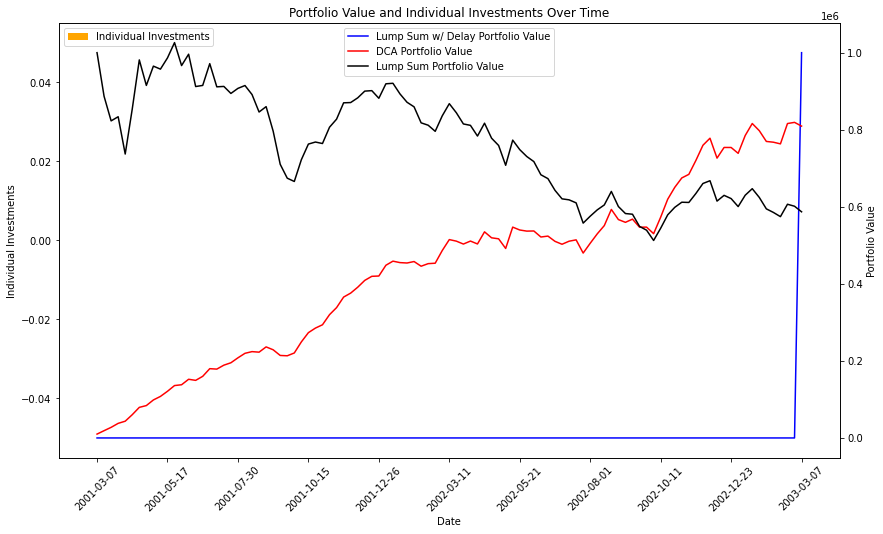

Initial Date : 2000-03-06
Start Date   : 2000-09-05 00:00:00
Lump Sum Date: 2002-09-05
End Date     : 2002-09-05


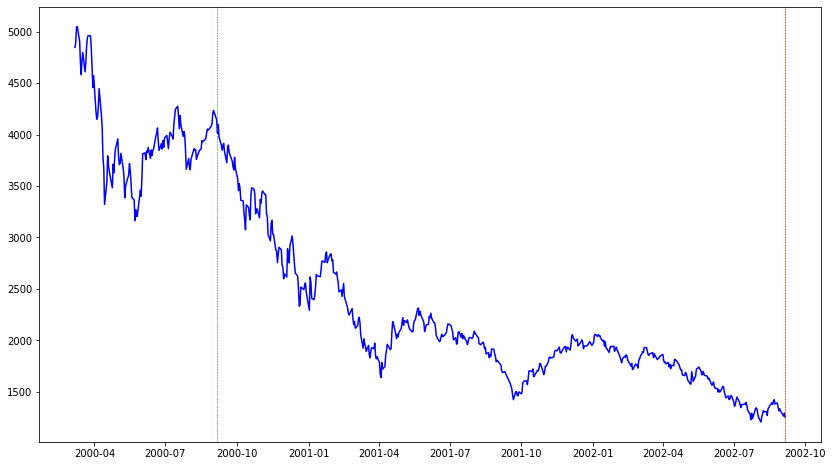

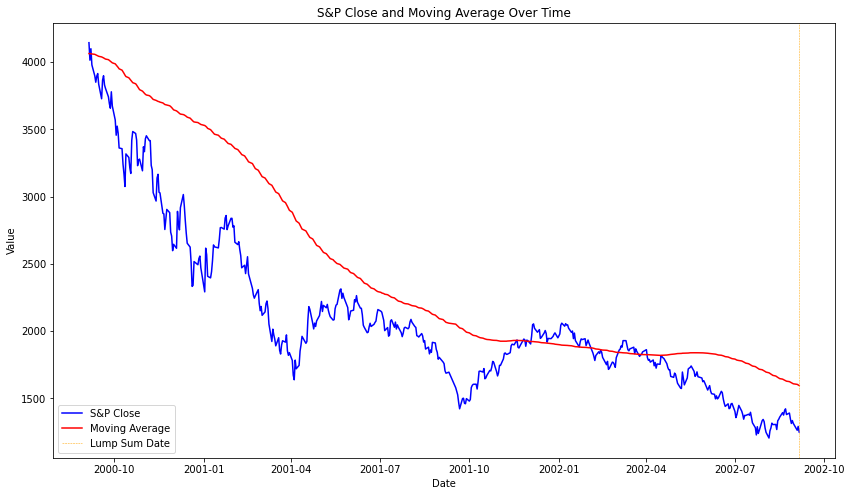

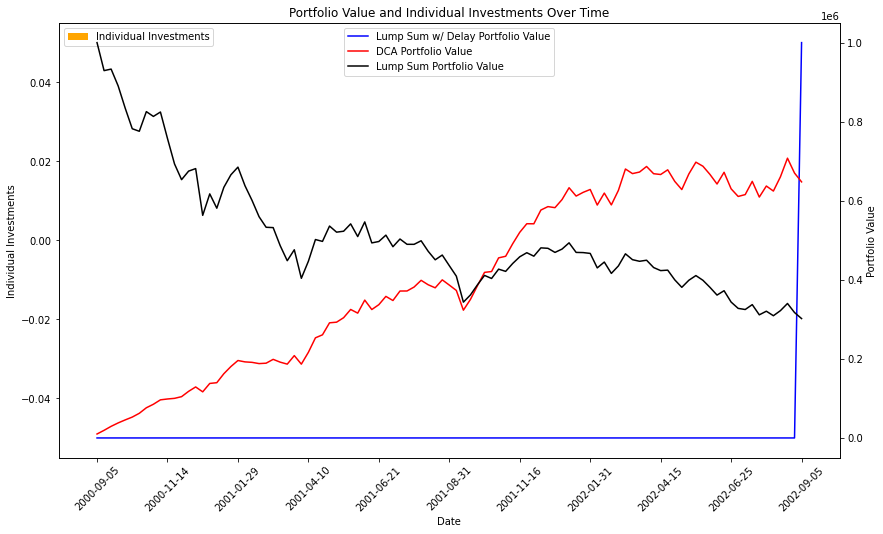

Initial Date : 2000-09-15
Start Date   : 2001-03-22 00:00:00
Lump Sum Date: 2003-03-17
End Date     : 2003-03-22


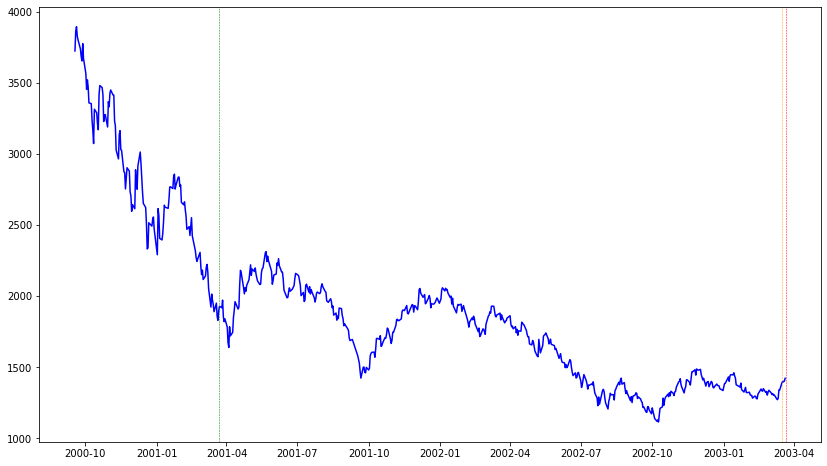

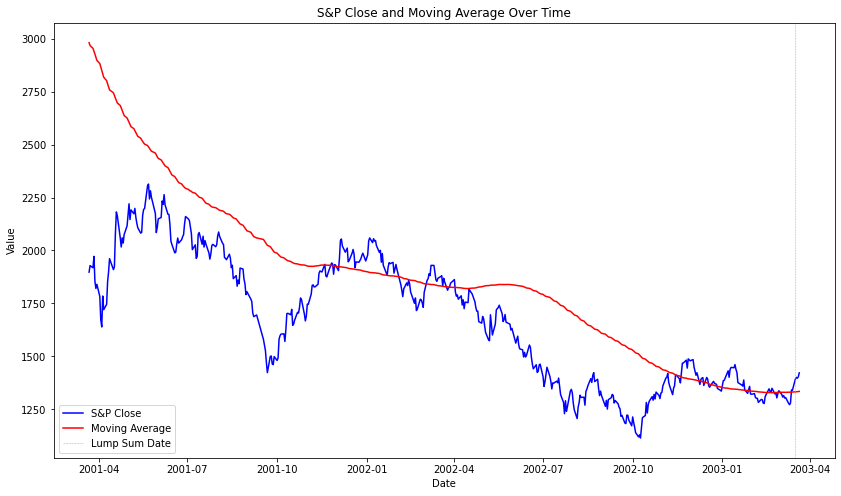

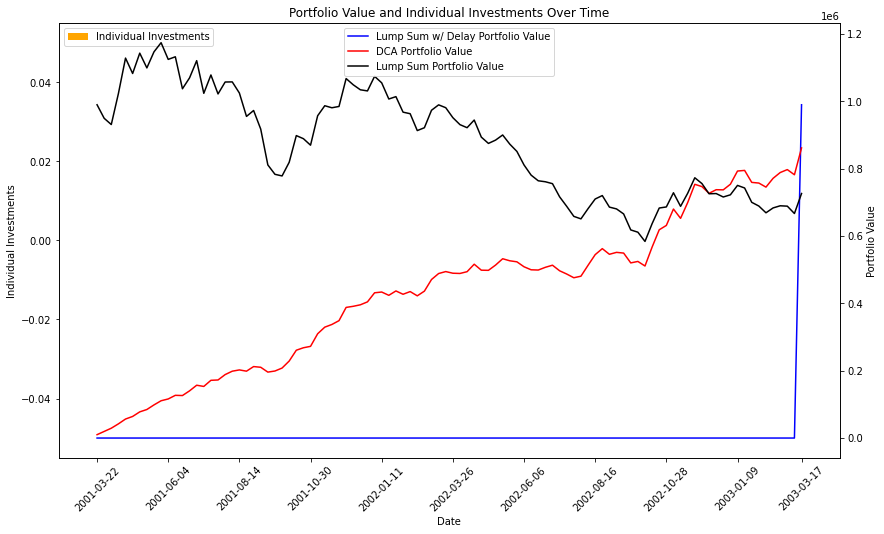

Initial Date : 2000-09-03
Start Date   : 2001-03-05 00:00:00
Lump Sum Date: 2003-03-05
End Date     : 2003-03-05


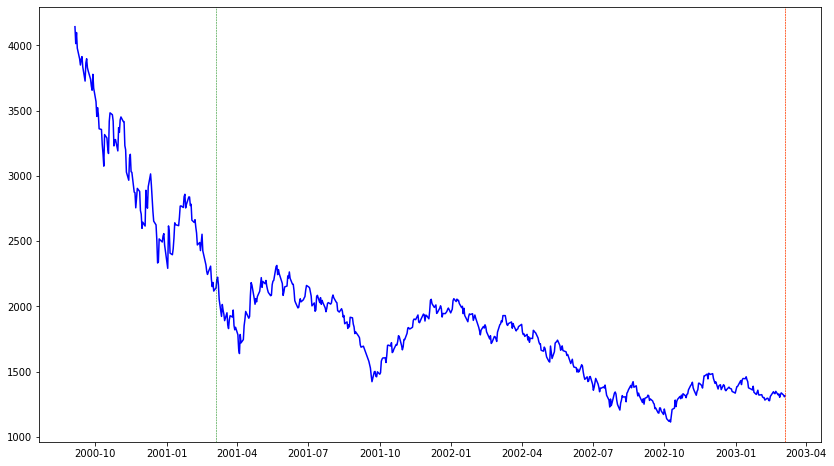

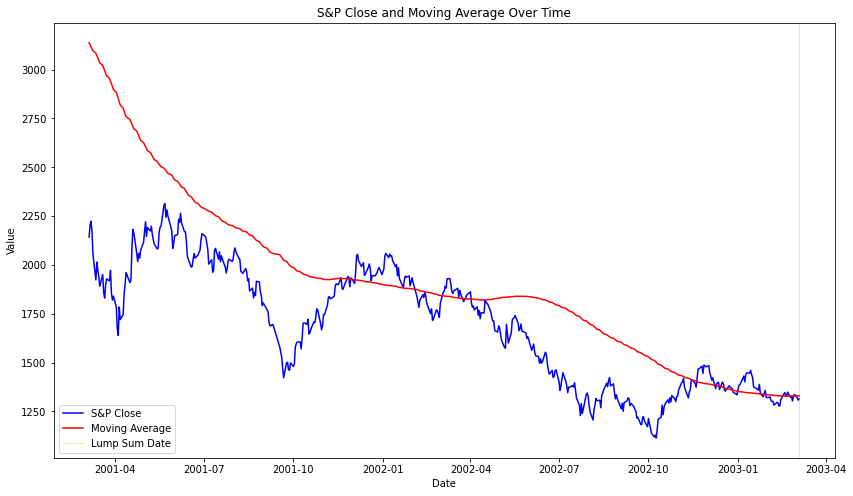

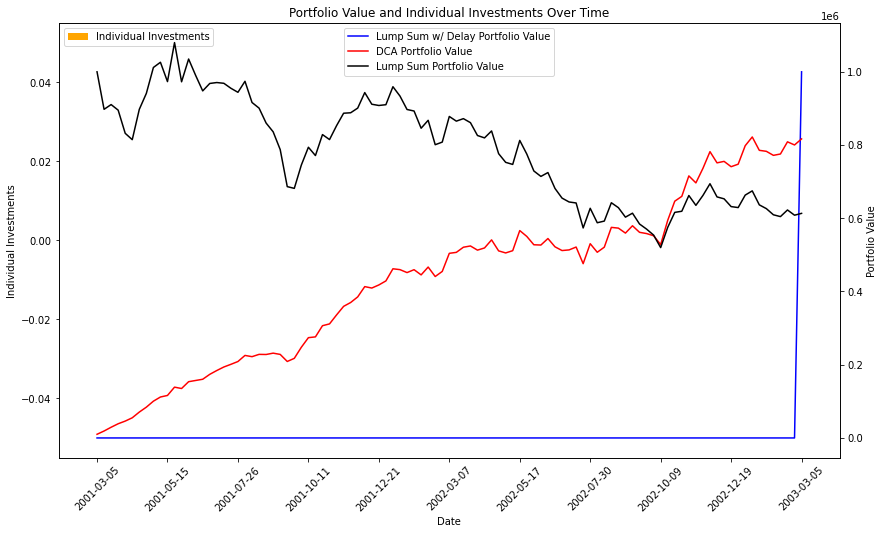

Initial Date : 2000-04-16
Start Date   : 2000-10-16 00:00:00
Lump Sum Date: 2002-10-16
End Date     : 2002-10-16


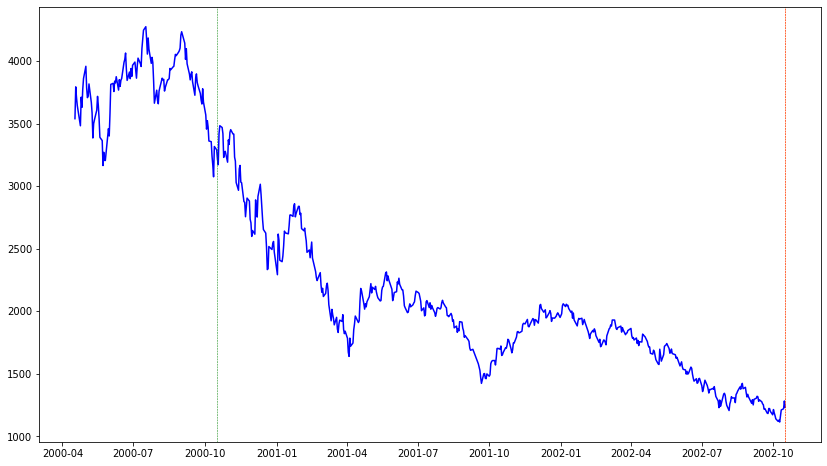

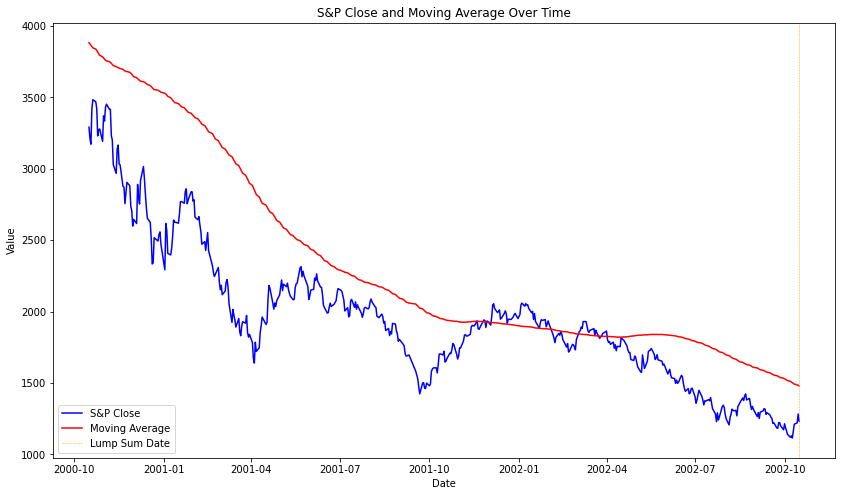

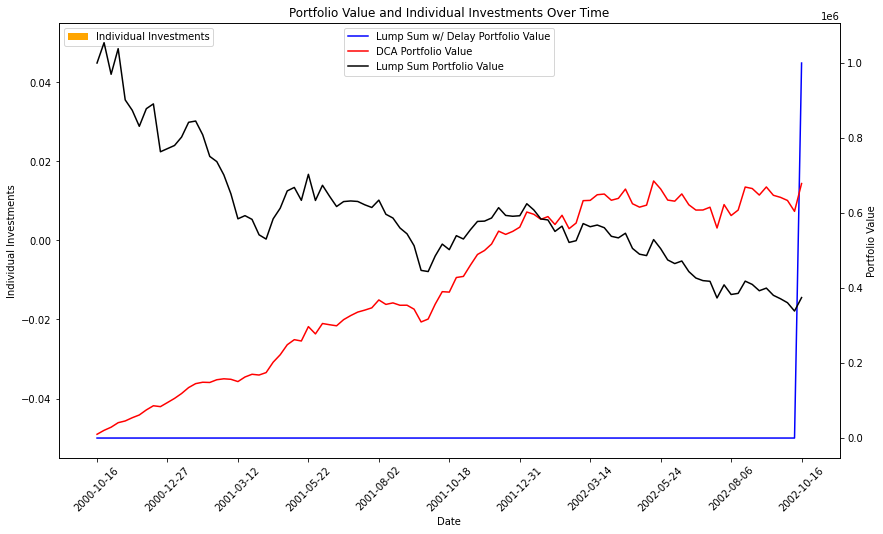

Initial Date : 2000-03-13
Start Date   : 2000-09-12 00:00:00
Lump Sum Date: 2002-09-12
End Date     : 2002-09-12


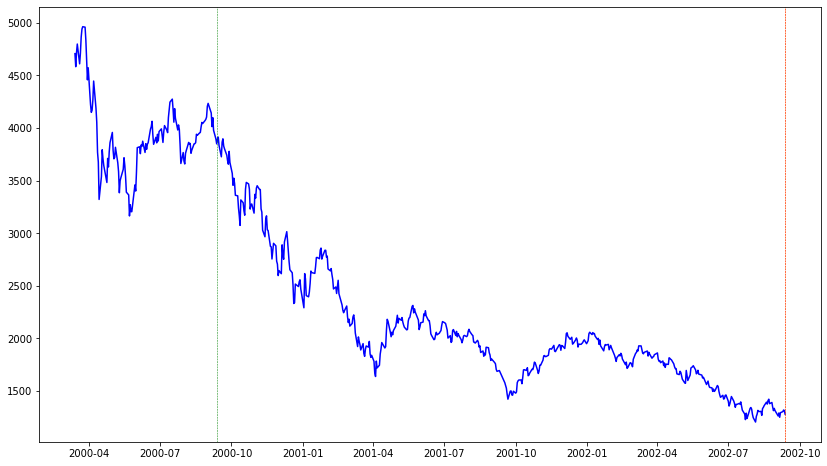

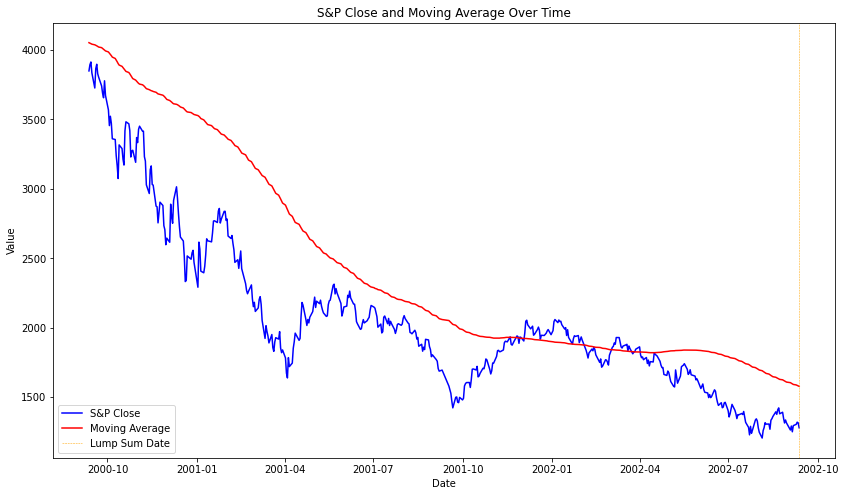

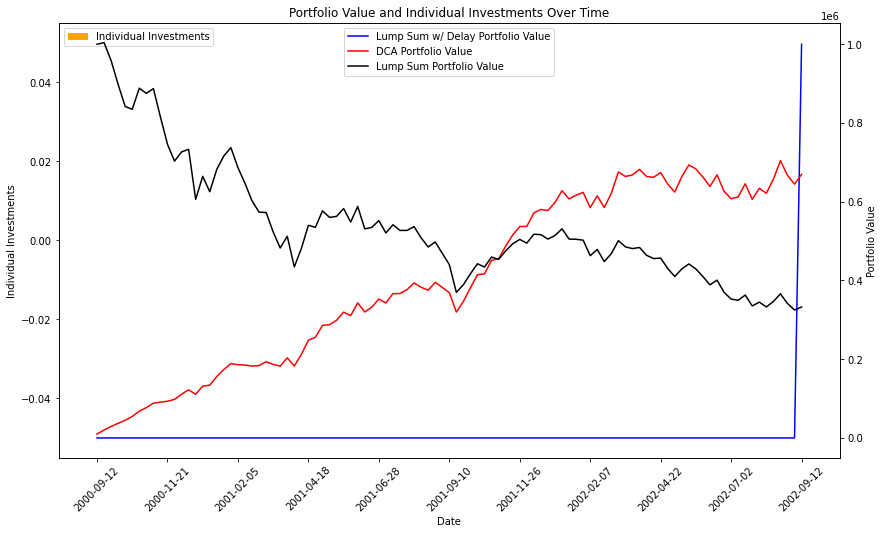

Initial Date : 2000-06-16
Start Date   : 2000-12-21 00:00:00
Lump Sum Date: 2002-12-16
End Date     : 2002-12-21


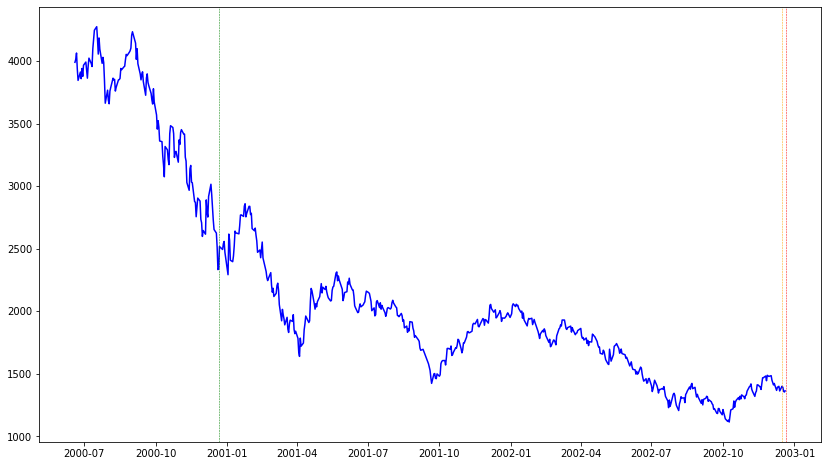

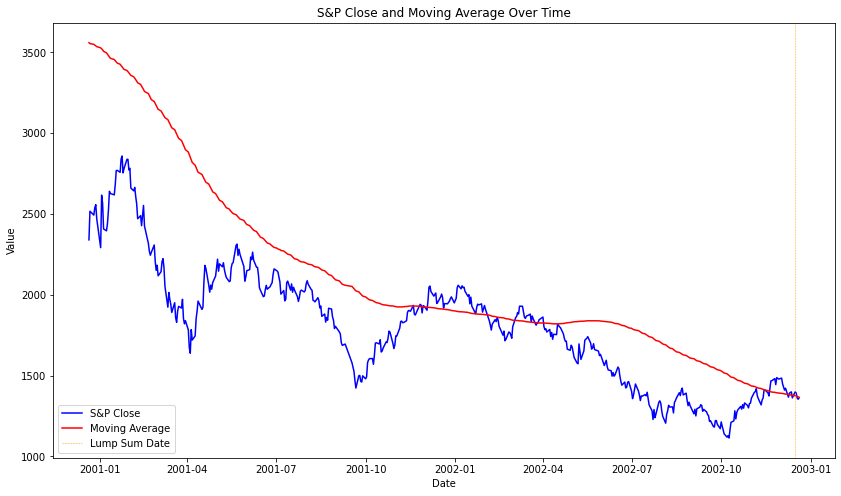

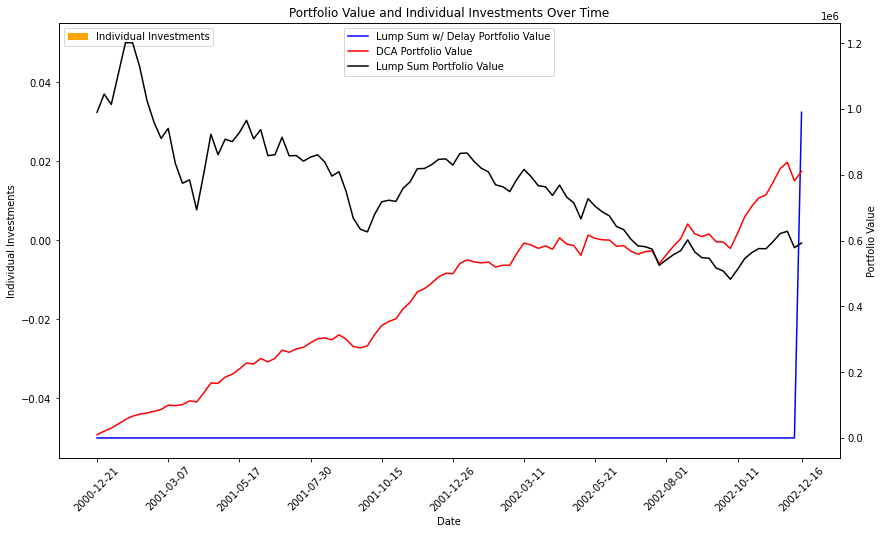

In [51]:
import matplotlib.pyplot as plt
from datetime import timedelta

start_dates = [results.loc[i]["Start Date"] for i in matching_delay_indices]
end_dates = [results.loc[i]["End Date"] for i in matching_delay_indices]
lump_sum_dates = [results.loc[i]["Lump Sum Date"] for i in matching_delay_indices]  # Extract lump sum dates
show_graph = True

for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
    print("Initial Date :", (lump_sum_date - timedelta(days=365 * train_years)).strftime('%Y-%m-%d'))
    print("Start Date   :", start_date)
    print("Lump Sum Date:", lump_sum_date.strftime('%Y-%m-%d'))
    print("End Date     :", end_date.strftime('%Y-%m-%d'))

    new_date = (lump_sum_date - timedelta(days=365 * train_years))

    # Plot size
    plt.figure(figsize=(14, 8))

    # Plot S&P Close
    plt.plot(sandp_time['close'][new_date:end_date], label='S&P Close', color='blue')

    # Plot vertical lines for start_date, lump_sum_date, and end_date
    plt.axvline(x=start_date, color='green', linestyle='--', linewidth=0.5)
    plt.axvline(x=lump_sum_date, color='orange', linestyle='--', linewidth=0.5)
    plt.axvline(x=end_date, color='red', linestyle='--', linewidth=0.5)

    # Plotting DCA analysis
    result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)

